# Generative Adversarial Networks

Classically, supervised methods are used to learn function mapping the sensory input of a neural network to his output, either for regression or for classification problems, by mainly applying error minimization methods. The methods are commonly referred to as discriminative models (https://en.wikipedia.org/wiki/Discriminative_model) since they are used to model the conditional probability distribution P(y|x).

Generative models (https://en.wikipedia.org/wiki/Generative_model) on the contrary, allow for modeling the conditional probability P(X|Y = y) of the observable random variable X, i.e., it allows for generating observations given specific instances of the target variable Y. 
Generative Adversarial Networks were fistly introduced in 2014 by Goodfellow et Al (http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf).
The main ide behind this approach is to build two different competing networks: a generator creating new instances and a discriminator evaluating them (https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0, https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87, https://github.com/eriklindernoren/Keras-GAN#adversarial-autoencoder, https://www.datacamp.com/community/tutorials/generative-adversarial-networks). The result is a combined network able to generate new instances that are up to a certain extent considered belonging to the dataset used to trained the discrminator.

In [1]:
%matplotlib inline

import numpy as np

from matplotlib import pyplot
from matplotlib.pyplot import imshow

import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose
from keras.optimizers import SGD, rmsprop
from keras.layers.convolutional import Conv2D, MaxPooling2D

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
initial_seed = 1234

('x_train shape:', (60000, 28, 28))
(60000, 'train samples')
(10000, 'test samples')


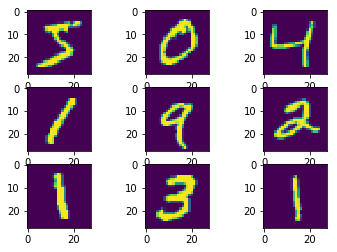

In [3]:
#from keras.datasets import cifar10
from keras.datasets import mnist

# https://keras.io/datasets/#mnist-database-of-handwritten-digits
# load mnist in a grayscale format bunch of images
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    imshow(x_train[i])
    imgplot = pyplot.imshow(x_train[i])

In [4]:
print np.amax(x_train)
# normalize the pixel values to have everything between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

255


In [5]:
# reshape to contain the channel information
x_train_ = np.reshape(x_train, (len(x_train), x_train.shape[1], x_train.shape[2], 1))
print "Reshaped train from", x_train.shape, "to", x_train_.shape
x_test_ = np.reshape(x_test, (len(x_test), x_train.shape[1], x_train.shape[2], 1))
print "Reshaped test from", x_test.shape, "to", x_test_.shape

Reshaped train from (60000, 28, 28) to (60000, 28, 28, 1)
Reshaped test from (10000, 28, 28) to (10000, 28, 28, 1)


In [6]:
input_shape = x_train_.shape[1:]
print input_shape

(28, 28, 1)


## Implementing the Discriminator

In [7]:
initial_discriminator_depth=64

discriminator = Sequential()
# stage 1
discriminator.add(Conv2D(initial_discriminator_depth,
                         (3, 3),
                         input_shape=input_shape,
                         padding="same",
                         activation="relu"))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Dropout(0.30))
# stage 2
discriminator.add(Conv2D(initial_discriminator_depth*2,
                         (3, 3),
                         padding="same",
                         activation="relu"))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Dropout(0.30))
# stage 3
discriminator.add(Conv2D(initial_discriminator_depth*3,
                         (3, 3),
                         padding="same",
                         activation="relu"))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Dropout(0.30))

# stage 4
discriminator.add(Flatten())
discriminator.add(Dense(initial_discriminator_depth*4, activation='relu'))
discriminator.add(Dropout(0.5))
# stage 4
discriminator.add(Dense(1, activation='sigmoid'))

In [8]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 192)         221376    
__________

In [9]:
optimizer = rmsprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

## Implementing the Generator

In [10]:
generator = Sequential()
input_noise_size = 100
initial_generator_depth = 256
dim = 7
# dim is 7 as we double it progressively to 14 and then 28 over the stages

# as in https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0

# stage 1 -> (dim, dim, depth)
generator.add(Dense(dim*dim*initial_generator_depth, 
                    input_dim=input_noise_size))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation("relu"))
# https://github.com/keras-team/keras/issues/4534
generator.add(Reshape( (dim, dim, initial_generator_depth) ))
generator.add(Dropout(0.4))

# stage 2 -> (2dim, 2dim, depth/2)
# de-convolution: conv2dtranspose
# https://keras.io/layers/convolutional/#conv2dtranspose
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(initial_generator_depth/2, 
                              5, # kernel_size
                              padding="same"))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation("relu"))

# stage 3 -> (4dim, 4dim, depth/4)
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(initial_generator_depth/4, 
                              5, # kernel_size
                              padding="same"))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation("relu"))

# stage 4 ->
generator.add(Conv2DTranspose(1, 
                              5, # kernel_size
                              padding="same"))
generator.add(Activation("sigmoid"))

In [11]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    
__________

## GAN Model

In [12]:
optimizer = rmsprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [13]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         2343681   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 738753    
Total params: 3,082,434
Trainable params: 3,056,962
Non-trainable params: 25,472
_________________________________________________________________


### Training of the discriminator

In [14]:
batch_size = 256

In [15]:
np.random.seed(initial_seed)

In [16]:
x_train_.shape[0]

60000

In [17]:
randomized_training_set = True
# use real data from x_train_ to train the discriminator, as well as newly created fake images
# split into batches of equal batch_size size
print x_train_.shape
if randomized_training_set:
    # select batch_size random instances from x_train
    x_train__ = x_train_[np.random.randint(0, x_train_.shape[0], size=batch_size), :, :, :]
else:
    x_train__ = x_train_
print x_train__.shape

(60000, 28, 28, 1)
(256, 28, 28, 1)


In [18]:
# generate random noise and use the generator to create fake images
noise = np.random.uniform(-1.0, 1.0, size=[x_train__.shape[0], 100])
print "noise", noise.shape
images_fake = generator.predict(noise)
print "fake images", images_fake.shape

noise (256, 100)
fake images (256, 28, 28, 1)


In [19]:
d_x = np.concatenate((x_train__, images_fake))
print d_x.shape

(512, 28, 28, 1)


In [20]:
# create a 2*batch_size array initially set to 1
d_y = np.ones([2*x_train__.shape[0], 1])
# set the second half (fake images) to 0
d_y[x_train__.shape[0]:, :] = 0

In [21]:
# train the discriminator
discriminator.trainable = True
d_loss = discriminator.train_on_batch(d_x, d_y)

### Training the generator-discriminator (GAN)

In [22]:
# create random input noise
input_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
gan_y = np.ones([batch_size, 1])
discriminator.trainable = False
ga_loss = gan.train_on_batch(input_noise, gan_y)

/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


### Iteratively Train the entire GAN

  0%|          | 2/1000 [00:00<02:51,  5.82it/s]

0: [Discriminator loss: 2.378484, acc: 0.500000] [GA loss: 0.774497, acc: 0.023438]
1: [Discriminator loss: 0.664844, acc: 0.505859] [GA loss: 0.664570, acc: 0.886719]


  0%|          | 4/1000 [00:00<02:54,  5.70it/s]

2: [Discriminator loss: 0.639609, acc: 0.500000] [GA loss: 0.688863, acc: 0.582031]
3: [Discriminator loss: 0.545707, acc: 0.500000] [GA loss: 0.395963, acc: 1.000000]


  1%|          | 6/1000 [00:01<02:55,  5.67it/s]

4: [Discriminator loss: 1.222245, acc: 0.500000] [GA loss: 0.812121, acc: 0.066406]
5: [Discriminator loss: 0.681062, acc: 0.500000] [GA loss: 0.652330, acc: 0.839844]


  1%|          | 8/1000 [00:01<02:59,  5.52it/s]

6: [Discriminator loss: 0.744209, acc: 0.500000] [GA loss: 0.613211, acc: 0.949219]
7: [Discriminator loss: 0.761312, acc: 0.500000] [GA loss: 0.606460, acc: 0.945312]


  1%|          | 10/1000 [00:01<02:59,  5.52it/s]

8: [Discriminator loss: 0.782616, acc: 0.500000] [GA loss: 0.637108, acc: 0.851562]
9: [Discriminator loss: 0.751755, acc: 0.500000] [GA loss: 0.631844, acc: 0.867188]


  1%|          | 12/1000 [00:02<02:56,  5.61it/s]

10: [Discriminator loss: 0.770627, acc: 0.500000] [GA loss: 0.664441, acc: 0.687500]
11: [Discriminator loss: 0.739067, acc: 0.500000] [GA loss: 0.658580, acc: 0.710938]


  1%|▏         | 14/1000 [00:02<02:55,  5.60it/s]

12: [Discriminator loss: 0.751768, acc: 0.500000] [GA loss: 0.709375, acc: 0.433594]
13: [Discriminator loss: 0.706902, acc: 0.498047] [GA loss: 0.626882, acc: 0.824219]


  2%|▏         | 16/1000 [00:02<02:54,  5.64it/s]

14: [Discriminator loss: 0.821359, acc: 0.500000] [GA loss: 0.882321, acc: 0.015625]
15: [Discriminator loss: 0.668692, acc: 0.617188] [GA loss: 0.527933, acc: 0.996094]


  2%|▏         | 18/1000 [00:03<02:51,  5.71it/s]

16: [Discriminator loss: 0.888341, acc: 0.500000] [GA loss: 0.799740, acc: 0.066406]
17: [Discriminator loss: 0.679876, acc: 0.552734] [GA loss: 0.663784, acc: 0.675781]


  2%|▏         | 20/1000 [00:03<02:47,  5.84it/s]

18: [Discriminator loss: 0.721803, acc: 0.500000] [GA loss: 0.647914, acc: 0.777344]
19: [Discriminator loss: 0.723827, acc: 0.500000] [GA loss: 0.687885, acc: 0.566406]


  2%|▏         | 22/1000 [00:03<02:51,  5.71it/s]

20: [Discriminator loss: 0.710382, acc: 0.500000] [GA loss: 0.718675, acc: 0.390625]
21: [Discriminator loss: 0.708131, acc: 0.505859] [GA loss: 0.727358, acc: 0.328125]


  2%|▏         | 24/1000 [00:04<02:50,  5.73it/s]

22: [Discriminator loss: 0.708227, acc: 0.500000] [GA loss: 0.737615, acc: 0.281250]
23: [Discriminator loss: 0.697023, acc: 0.501953] [GA loss: 0.739890, acc: 0.296875]


  3%|▎         | 26/1000 [00:04<02:51,  5.68it/s]

24: [Discriminator loss: 0.712764, acc: 0.501953] [GA loss: 0.812736, acc: 0.085938]
25: [Discriminator loss: 0.661559, acc: 0.542969] [GA loss: 0.574889, acc: 0.925781]


  3%|▎         | 28/1000 [00:04<02:49,  5.74it/s]

26: [Discriminator loss: 1.032780, acc: 0.500000] [GA loss: 1.017357, acc: 0.000000]
27: [Discriminator loss: 0.724270, acc: 0.500000] [GA loss: 0.834968, acc: 0.000000]


  3%|▎         | 30/1000 [00:05<02:51,  5.65it/s]

28: [Discriminator loss: 0.699963, acc: 0.513672] [GA loss: 0.754189, acc: 0.015625]
29: [Discriminator loss: 0.676146, acc: 0.701172] [GA loss: 0.625896, acc: 0.957031]


  3%|▎         | 32/1000 [00:05<02:53,  5.59it/s]

30: [Discriminator loss: 0.708175, acc: 0.500000] [GA loss: 0.632494, acc: 0.949219]
31: [Discriminator loss: 0.714124, acc: 0.500000] [GA loss: 0.643211, acc: 0.875000]


  3%|▎         | 34/1000 [00:06<02:48,  5.73it/s]

32: [Discriminator loss: 0.717383, acc: 0.500000] [GA loss: 0.652400, acc: 0.867188]
33: [Discriminator loss: 0.715161, acc: 0.500000] [GA loss: 0.663246, acc: 0.781250]


  4%|▎         | 36/1000 [00:06<02:47,  5.76it/s]

34: [Discriminator loss: 0.711155, acc: 0.500000] [GA loss: 0.672839, acc: 0.687500]
35: [Discriminator loss: 0.710039, acc: 0.500000] [GA loss: 0.678761, acc: 0.656250]


  4%|▍         | 38/1000 [00:06<02:49,  5.69it/s]

36: [Discriminator loss: 0.702400, acc: 0.500000] [GA loss: 0.673532, acc: 0.632812]
37: [Discriminator loss: 0.706482, acc: 0.498047] [GA loss: 0.704906, acc: 0.425781]


  4%|▍         | 40/1000 [00:07<02:52,  5.57it/s]

38: [Discriminator loss: 0.692478, acc: 0.500000] [GA loss: 0.680503, acc: 0.609375]
39: [Discriminator loss: 0.712110, acc: 0.500000] [GA loss: 0.772377, acc: 0.046875]


  4%|▍         | 42/1000 [00:07<02:50,  5.62it/s]

40: [Discriminator loss: 0.682407, acc: 0.601562] [GA loss: 0.676595, acc: 0.640625]
41: [Discriminator loss: 0.704181, acc: 0.500000] [GA loss: 0.740751, acc: 0.152344]


  4%|▍         | 44/1000 [00:07<02:48,  5.68it/s]

42: [Discriminator loss: 0.676246, acc: 0.533203] [GA loss: 0.644847, acc: 0.843750]
43: [Discriminator loss: 0.754875, acc: 0.500000] [GA loss: 0.829316, acc: 0.000000]


  5%|▍         | 46/1000 [00:08<02:48,  5.67it/s]

44: [Discriminator loss: 0.691549, acc: 0.517578] [GA loss: 0.740795, acc: 0.070312]
45: [Discriminator loss: 0.686167, acc: 0.560547] [GA loss: 0.670959, acc: 0.753906]


  5%|▍         | 48/1000 [00:08<02:49,  5.63it/s]

46: [Discriminator loss: 0.704749, acc: 0.498047] [GA loss: 0.673929, acc: 0.687500]
47: [Discriminator loss: 0.701226, acc: 0.500000] [GA loss: 0.693023, acc: 0.480469]


  5%|▌         | 50/1000 [00:08<02:47,  5.67it/s]

48: [Discriminator loss: 0.696300, acc: 0.500000] [GA loss: 0.690286, acc: 0.542969]
49: [Discriminator loss: 0.702401, acc: 0.500000] [GA loss: 0.684291, acc: 0.566406]


  5%|▌         | 52/1000 [00:09<02:48,  5.62it/s]

50: [Discriminator loss: 0.708664, acc: 0.500000] [GA loss: 0.718059, acc: 0.296875]
51: [Discriminator loss: 0.693762, acc: 0.503906] [GA loss: 0.693749, acc: 0.480469]


  5%|▌         | 54/1000 [00:09<02:50,  5.53it/s]

52: [Discriminator loss: 0.700712, acc: 0.500000] [GA loss: 0.751724, acc: 0.074219]
53: [Discriminator loss: 0.684997, acc: 0.525391] [GA loss: 0.666237, acc: 0.761719]


  6%|▌         | 56/1000 [00:09<02:46,  5.67it/s]

54: [Discriminator loss: 0.729485, acc: 0.500000] [GA loss: 0.820789, acc: 0.000000]
55: [Discriminator loss: 0.693694, acc: 0.507812] [GA loss: 0.738161, acc: 0.078125]


  6%|▌         | 58/1000 [00:10<02:49,  5.57it/s]

56: [Discriminator loss: 0.682949, acc: 0.582031] [GA loss: 0.674155, acc: 0.703125]
57: [Discriminator loss: 0.695170, acc: 0.500000] [GA loss: 0.682048, acc: 0.582031]


  6%|▌         | 60/1000 [00:10<02:48,  5.57it/s]

58: [Discriminator loss: 0.692652, acc: 0.500000] [GA loss: 0.697402, acc: 0.445312]
59: [Discriminator loss: 0.691254, acc: 0.500000] [GA loss: 0.696919, acc: 0.472656]


  6%|▌         | 62/1000 [00:11<02:50,  5.51it/s]

60: [Discriminator loss: 0.688197, acc: 0.501953] [GA loss: 0.723599, acc: 0.218750]
61: [Discriminator loss: 0.687162, acc: 0.507812] [GA loss: 0.705057, acc: 0.363281]


  6%|▋         | 64/1000 [00:11<02:45,  5.66it/s]

62: [Discriminator loss: 0.700439, acc: 0.500000] [GA loss: 0.774984, acc: 0.007812]
63: [Discriminator loss: 0.680581, acc: 0.619141] [GA loss: 0.676545, acc: 0.628906]


  7%|▋         | 66/1000 [00:11<02:46,  5.61it/s]

64: [Discriminator loss: 0.737675, acc: 0.500000] [GA loss: 0.819415, acc: 0.000000]
65: [Discriminator loss: 0.693021, acc: 0.503906] [GA loss: 0.734673, acc: 0.082031]


  7%|▋         | 68/1000 [00:12<02:47,  5.56it/s]

66: [Discriminator loss: 0.692400, acc: 0.468750] [GA loss: 0.689006, acc: 0.550781]
67: [Discriminator loss: 0.708697, acc: 0.498047] [GA loss: 0.718094, acc: 0.191406]


  7%|▋         | 70/1000 [00:12<02:45,  5.60it/s]

68: [Discriminator loss: 0.686054, acc: 0.505859] [GA loss: 0.676583, acc: 0.683594]
69: [Discriminator loss: 0.708340, acc: 0.500000] [GA loss: 0.718526, acc: 0.230469]


  7%|▋         | 72/1000 [00:12<02:45,  5.60it/s]

70: [Discriminator loss: 0.691456, acc: 0.513672] [GA loss: 0.653983, acc: 0.824219]
71: [Discriminator loss: 0.729814, acc: 0.500000] [GA loss: 0.781866, acc: 0.000000]


  7%|▋         | 74/1000 [00:13<02:46,  5.57it/s]

72: [Discriminator loss: 0.689813, acc: 0.527344] [GA loss: 0.732782, acc: 0.085938]
73: [Discriminator loss: 0.688362, acc: 0.548828] [GA loss: 0.684708, acc: 0.554688]


  8%|▊         | 76/1000 [00:13<02:43,  5.64it/s]

74: [Discriminator loss: 0.694019, acc: 0.500000] [GA loss: 0.676947, acc: 0.695312]
75: [Discriminator loss: 0.694504, acc: 0.500000] [GA loss: 0.694059, acc: 0.503906]


  8%|▊         | 78/1000 [00:13<02:45,  5.58it/s]

76: [Discriminator loss: 0.692831, acc: 0.501953] [GA loss: 0.701022, acc: 0.386719]
77: [Discriminator loss: 0.694373, acc: 0.501953] [GA loss: 0.712296, acc: 0.300781]


  8%|▊         | 80/1000 [00:14<02:47,  5.48it/s]

78: [Discriminator loss: 0.686611, acc: 0.505859] [GA loss: 0.705892, acc: 0.339844]
79: [Discriminator loss: 0.718169, acc: 0.500000] [GA loss: 0.782262, acc: 0.000000]


  8%|▊         | 82/1000 [00:14<02:48,  5.44it/s]

80: [Discriminator loss: 0.684668, acc: 0.587891] [GA loss: 0.696806, acc: 0.417969]
81: [Discriminator loss: 0.711176, acc: 0.496094] [GA loss: 0.733512, acc: 0.062500]


  8%|▊         | 84/1000 [00:14<02:45,  5.54it/s]

82: [Discriminator loss: 0.683750, acc: 0.580078] [GA loss: 0.659755, acc: 0.808594]
83: [Discriminator loss: 0.715603, acc: 0.500000] [GA loss: 0.763187, acc: 0.007812]


  9%|▊         | 86/1000 [00:15<02:44,  5.55it/s]

84: [Discriminator loss: 0.687842, acc: 0.550781] [GA loss: 0.705165, acc: 0.316406]
85: [Discriminator loss: 0.686568, acc: 0.505859] [GA loss: 0.671235, acc: 0.710938]


  9%|▉         | 88/1000 [00:15<02:41,  5.64it/s]

86: [Discriminator loss: 0.699063, acc: 0.500000] [GA loss: 0.732294, acc: 0.085938]
87: [Discriminator loss: 0.684210, acc: 0.564453] [GA loss: 0.676280, acc: 0.664062]


  9%|▉         | 90/1000 [00:16<02:47,  5.44it/s]

88: [Discriminator loss: 0.697077, acc: 0.500000] [GA loss: 0.757403, acc: 0.011719]
89: [Discriminator loss: 0.686527, acc: 0.593750] [GA loss: 0.690167, acc: 0.496094]


  9%|▉         | 92/1000 [00:16<02:44,  5.51it/s]

90: [Discriminator loss: 0.691547, acc: 0.500000] [GA loss: 0.744694, acc: 0.042969]
91: [Discriminator loss: 0.682094, acc: 0.576172] [GA loss: 0.654566, acc: 0.851562]


  9%|▉         | 94/1000 [00:16<02:43,  5.53it/s]

92: [Discriminator loss: 0.757229, acc: 0.500000] [GA loss: 0.829765, acc: 0.000000]
93: [Discriminator loss: 0.694944, acc: 0.500000] [GA loss: 0.767309, acc: 0.000000]


 10%|▉         | 96/1000 [00:17<02:39,  5.67it/s]

94: [Discriminator loss: 0.691676, acc: 0.500000] [GA loss: 0.740329, acc: 0.007812]
95: [Discriminator loss: 0.690203, acc: 0.542969] [GA loss: 0.716889, acc: 0.128906]


 10%|▉         | 98/1000 [00:17<02:38,  5.71it/s]

96: [Discriminator loss: 0.691764, acc: 0.515625] [GA loss: 0.694099, acc: 0.476562]
97: [Discriminator loss: 0.690538, acc: 0.498047] [GA loss: 0.672213, acc: 0.800781]


 10%|█         | 100/1000 [00:17<02:39,  5.64it/s]

98: [Discriminator loss: 0.691005, acc: 0.501953] [GA loss: 0.666958, acc: 0.824219]
99: [Discriminator loss: 0.690813, acc: 0.500000] [GA loss: 0.652844, acc: 0.917969]


 10%|█         | 102/1000 [00:18<02:41,  5.55it/s]

100: [Discriminator loss: 0.705992, acc: 0.500000] [GA loss: 0.706543, acc: 0.277344]
101: [Discriminator loss: 0.685316, acc: 0.513672] [GA loss: 0.655654, acc: 0.890625]


 10%|█         | 104/1000 [00:18<02:41,  5.55it/s]

102: [Discriminator loss: 0.718852, acc: 0.500000] [GA loss: 0.748058, acc: 0.007812]
103: [Discriminator loss: 0.687437, acc: 0.595703] [GA loss: 0.699390, acc: 0.417969]


 11%|█         | 106/1000 [00:18<02:40,  5.56it/s]

104: [Discriminator loss: 0.689531, acc: 0.505859] [GA loss: 0.670174, acc: 0.769531]
105: [Discriminator loss: 0.701072, acc: 0.501953] [GA loss: 0.694203, acc: 0.468750]


 11%|█         | 108/1000 [00:19<02:38,  5.63it/s]

106: [Discriminator loss: 0.694075, acc: 0.500000] [GA loss: 0.710064, acc: 0.273438]
107: [Discriminator loss: 0.690215, acc: 0.505859] [GA loss: 0.697255, acc: 0.464844]


 11%|█         | 110/1000 [00:19<02:37,  5.65it/s]

108: [Discriminator loss: 0.687288, acc: 0.500000] [GA loss: 0.718914, acc: 0.160156]
109: [Discriminator loss: 0.681630, acc: 0.519531] [GA loss: 0.677932, acc: 0.636719]


 11%|█         | 112/1000 [00:19<02:36,  5.67it/s]

110: [Discriminator loss: 0.729749, acc: 0.500000] [GA loss: 0.818773, acc: 0.000000]
111: [Discriminator loss: 0.694060, acc: 0.501953] [GA loss: 0.767083, acc: 0.000000]


 11%|█▏        | 114/1000 [00:20<02:35,  5.71it/s]

112: [Discriminator loss: 0.690849, acc: 0.509766] [GA loss: 0.731925, acc: 0.042969]
113: [Discriminator loss: 0.689360, acc: 0.583984] [GA loss: 0.701179, acc: 0.347656]


 12%|█▏        | 116/1000 [00:20<02:37,  5.60it/s]

114: [Discriminator loss: 0.690550, acc: 0.519531] [GA loss: 0.660690, acc: 0.847656]
115: [Discriminator loss: 0.694421, acc: 0.500000] [GA loss: 0.673229, acc: 0.707031]


 12%|█▏        | 118/1000 [00:21<02:38,  5.56it/s]

116: [Discriminator loss: 0.694717, acc: 0.500000] [GA loss: 0.692277, acc: 0.476562]
117: [Discriminator loss: 0.683460, acc: 0.500000] [GA loss: 0.678190, acc: 0.644531]


 12%|█▏        | 120/1000 [00:21<02:41,  5.44it/s]

118: [Discriminator loss: 0.695103, acc: 0.500000] [GA loss: 0.726707, acc: 0.117188]
119: [Discriminator loss: 0.683754, acc: 0.568359] [GA loss: 0.658561, acc: 0.820312]


 12%|█▏        | 122/1000 [00:21<02:35,  5.66it/s]

120: [Discriminator loss: 0.714233, acc: 0.500000] [GA loss: 0.770181, acc: 0.000000]
121: [Discriminator loss: 0.692429, acc: 0.507812] [GA loss: 0.732985, acc: 0.066406]


 12%|█▏        | 124/1000 [00:22<02:37,  5.57it/s]

122: [Discriminator loss: 0.686340, acc: 0.599609] [GA loss: 0.686625, acc: 0.601562]
123: [Discriminator loss: 0.686940, acc: 0.501953] [GA loss: 0.672147, acc: 0.750000]


 13%|█▎        | 126/1000 [00:22<02:32,  5.73it/s]

124: [Discriminator loss: 0.687878, acc: 0.501953] [GA loss: 0.689775, acc: 0.527344]
125: [Discriminator loss: 0.693184, acc: 0.498047] [GA loss: 0.729716, acc: 0.101562]


 13%|█▎        | 128/1000 [00:22<02:38,  5.51it/s]

126: [Discriminator loss: 0.683260, acc: 0.546875] [GA loss: 0.633888, acc: 0.929688]
127: [Discriminator loss: 0.793465, acc: 0.500000] [GA loss: 0.800018, acc: 0.000000]


 13%|█▎        | 130/1000 [00:23<02:34,  5.63it/s]

128: [Discriminator loss: 0.695223, acc: 0.500000] [GA loss: 0.766359, acc: 0.000000]
129: [Discriminator loss: 0.693137, acc: 0.501953] [GA loss: 0.745502, acc: 0.000000]


 13%|█▎        | 132/1000 [00:23<02:33,  5.65it/s]

130: [Discriminator loss: 0.691168, acc: 0.515625] [GA loss: 0.732232, acc: 0.000000]
131: [Discriminator loss: 0.689780, acc: 0.558594] [GA loss: 0.713119, acc: 0.121094]


 13%|█▎        | 134/1000 [00:23<02:33,  5.65it/s]

132: [Discriminator loss: 0.685977, acc: 0.568359] [GA loss: 0.675926, acc: 0.753906]
133: [Discriminator loss: 0.695541, acc: 0.500000] [GA loss: 0.662166, acc: 0.902344]


 14%|█▎        | 136/1000 [00:24<02:35,  5.57it/s]

134: [Discriminator loss: 0.696778, acc: 0.500000] [GA loss: 0.652318, acc: 0.960938]
135: [Discriminator loss: 0.703329, acc: 0.500000] [GA loss: 0.668725, acc: 0.824219]


 14%|█▍        | 138/1000 [00:24<02:32,  5.65it/s]

136: [Discriminator loss: 0.690012, acc: 0.500000] [GA loss: 0.645826, acc: 0.964844]
137: [Discriminator loss: 0.707621, acc: 0.500000] [GA loss: 0.690475, acc: 0.535156]


 14%|█▍        | 140/1000 [00:24<02:35,  5.53it/s]

138: [Discriminator loss: 0.683189, acc: 0.515625] [GA loss: 0.649300, acc: 0.882812]
139: [Discriminator loss: 0.713098, acc: 0.500000] [GA loss: 0.679164, acc: 0.648438]


 14%|█▍        | 142/1000 [00:25<02:31,  5.67it/s]

140: [Discriminator loss: 0.688841, acc: 0.503906] [GA loss: 0.628586, acc: 0.964844]
141: [Discriminator loss: 0.785861, acc: 0.500000] [GA loss: 0.754020, acc: 0.000000]


 14%|█▍        | 144/1000 [00:25<02:32,  5.63it/s]

142: [Discriminator loss: 0.692107, acc: 0.511719] [GA loss: 0.728050, acc: 0.015625]
143: [Discriminator loss: 0.689740, acc: 0.564453] [GA loss: 0.711357, acc: 0.132812]


 15%|█▍        | 146/1000 [00:26<02:33,  5.55it/s]

144: [Discriminator loss: 0.690868, acc: 0.531250] [GA loss: 0.684619, acc: 0.656250]
145: [Discriminator loss: 0.692175, acc: 0.507812] [GA loss: 0.659962, acc: 0.921875]


 15%|█▍        | 148/1000 [00:26<02:31,  5.64it/s]

146: [Discriminator loss: 0.690575, acc: 0.501953] [GA loss: 0.628875, acc: 0.996094]
147: [Discriminator loss: 0.710089, acc: 0.500000] [GA loss: 0.660476, acc: 0.890625]


 15%|█▌        | 150/1000 [00:26<02:28,  5.71it/s]

148: [Discriminator loss: 0.702067, acc: 0.500000] [GA loss: 0.665406, acc: 0.878906]
149: [Discriminator loss: 0.697230, acc: 0.500000] [GA loss: 0.671409, acc: 0.789062]


 15%|█▌        | 152/1000 [00:27<02:27,  5.74it/s]

150: [Discriminator loss: 0.695068, acc: 0.500000] [GA loss: 0.676926, acc: 0.781250]
151: [Discriminator loss: 0.690119, acc: 0.498047] [GA loss: 0.659527, acc: 0.910156]


 15%|█▌        | 154/1000 [00:27<02:29,  5.67it/s]

152: [Discriminator loss: 0.694041, acc: 0.500000] [GA loss: 0.690359, acc: 0.511719]
153: [Discriminator loss: 0.689645, acc: 0.505859] [GA loss: 0.651122, acc: 0.941406]


 16%|█▌        | 156/1000 [00:27<02:28,  5.67it/s]

154: [Discriminator loss: 0.733044, acc: 0.500000] [GA loss: 0.750661, acc: 0.000000]
155: [Discriminator loss: 0.690212, acc: 0.525391] [GA loss: 0.721503, acc: 0.031250]


 16%|█▌        | 158/1000 [00:28<02:25,  5.78it/s]

156: [Discriminator loss: 0.691105, acc: 0.558594] [GA loss: 0.699620, acc: 0.335938]
157: [Discriminator loss: 0.687163, acc: 0.566406] [GA loss: 0.670412, acc: 0.839844]


 16%|█▌        | 160/1000 [00:28<02:29,  5.63it/s]

158: [Discriminator loss: 0.686036, acc: 0.505859] [GA loss: 0.625782, acc: 0.996094]
159: [Discriminator loss: 0.722355, acc: 0.500000] [GA loss: 0.696675, acc: 0.425781]


 16%|█▌        | 162/1000 [00:28<02:26,  5.73it/s]

160: [Discriminator loss: 0.689196, acc: 0.539062] [GA loss: 0.662735, acc: 0.898438]
161: [Discriminator loss: 0.697045, acc: 0.501953] [GA loss: 0.668402, acc: 0.828125]


 16%|█▋        | 164/1000 [00:29<02:26,  5.70it/s]

162: [Discriminator loss: 0.690727, acc: 0.503906] [GA loss: 0.659706, acc: 0.890625]
163: [Discriminator loss: 0.698218, acc: 0.503906] [GA loss: 0.667347, acc: 0.855469]


 17%|█▋        | 166/1000 [00:29<02:29,  5.57it/s]

164: [Discriminator loss: 0.709898, acc: 0.498047] [GA loss: 0.701024, acc: 0.316406]
165: [Discriminator loss: 0.683906, acc: 0.537109] [GA loss: 0.649167, acc: 0.878906]


 17%|█▋        | 168/1000 [00:29<02:30,  5.53it/s]

166: [Discriminator loss: 0.758723, acc: 0.500000] [GA loss: 0.726783, acc: 0.066406]
167: [Discriminator loss: 0.690308, acc: 0.548828] [GA loss: 0.693821, acc: 0.472656]


 17%|█▋        | 170/1000 [00:30<02:27,  5.64it/s]

168: [Discriminator loss: 0.695117, acc: 0.498047] [GA loss: 0.684908, acc: 0.621094]
169: [Discriminator loss: 0.699011, acc: 0.494141] [GA loss: 0.689605, acc: 0.566406]


 17%|█▋        | 172/1000 [00:30<02:23,  5.75it/s]

170: [Discriminator loss: 0.684977, acc: 0.511719] [GA loss: 0.657805, acc: 0.882812]
171: [Discriminator loss: 0.715887, acc: 0.500000] [GA loss: 0.715482, acc: 0.148438]


 17%|█▋        | 174/1000 [00:30<02:23,  5.75it/s]

172: [Discriminator loss: 0.687709, acc: 0.562500] [GA loss: 0.677143, acc: 0.699219]
173: [Discriminator loss: 0.703501, acc: 0.500000] [GA loss: 0.673557, acc: 0.742188]


 18%|█▊        | 176/1000 [00:31<02:22,  5.77it/s]

174: [Discriminator loss: 0.699786, acc: 0.498047] [GA loss: 0.666545, acc: 0.835938]
175: [Discriminator loss: 0.697908, acc: 0.501953] [GA loss: 0.689318, acc: 0.515625]


 18%|█▊        | 178/1000 [00:31<02:25,  5.66it/s]

176: [Discriminator loss: 0.690745, acc: 0.509766] [GA loss: 0.668620, acc: 0.753906]
177: [Discriminator loss: 0.698349, acc: 0.500000] [GA loss: 0.699685, acc: 0.367188]


 18%|█▊        | 180/1000 [00:32<02:24,  5.69it/s]

178: [Discriminator loss: 0.689037, acc: 0.523438] [GA loss: 0.663505, acc: 0.777344]
179: [Discriminator loss: 0.708418, acc: 0.501953] [GA loss: 0.717440, acc: 0.156250]


 18%|█▊        | 182/1000 [00:32<02:21,  5.77it/s]

180: [Discriminator loss: 0.685258, acc: 0.591797] [GA loss: 0.649168, acc: 0.886719]
181: [Discriminator loss: 0.743444, acc: 0.500000] [GA loss: 0.739599, acc: 0.035156]


 18%|█▊        | 184/1000 [00:32<02:20,  5.80it/s]

182: [Discriminator loss: 0.685631, acc: 0.603516] [GA loss: 0.686290, acc: 0.488281]
183: [Discriminator loss: 0.718647, acc: 0.496094] [GA loss: 0.722553, acc: 0.089844]


 19%|█▊        | 186/1000 [00:33<02:21,  5.77it/s]

184: [Discriminator loss: 0.693907, acc: 0.523438] [GA loss: 0.696694, acc: 0.402344]
185: [Discriminator loss: 0.691509, acc: 0.519531] [GA loss: 0.671233, acc: 0.750000]


 19%|█▉        | 188/1000 [00:33<02:22,  5.68it/s]

186: [Discriminator loss: 0.696123, acc: 0.500000] [GA loss: 0.660536, acc: 0.828125]
187: [Discriminator loss: 0.698233, acc: 0.500000] [GA loss: 0.670706, acc: 0.738281]


 19%|█▉        | 190/1000 [00:33<02:21,  5.73it/s]

188: [Discriminator loss: 0.698242, acc: 0.507812] [GA loss: 0.667605, acc: 0.785156]
189: [Discriminator loss: 0.694963, acc: 0.503906] [GA loss: 0.680993, acc: 0.640625]


 19%|█▉        | 192/1000 [00:34<02:22,  5.66it/s]

190: [Discriminator loss: 0.693985, acc: 0.509766] [GA loss: 0.679705, acc: 0.656250]
191: [Discriminator loss: 0.696504, acc: 0.501953] [GA loss: 0.704639, acc: 0.335938]


 19%|█▉        | 194/1000 [00:34<02:20,  5.74it/s]

192: [Discriminator loss: 0.691008, acc: 0.501953] [GA loss: 0.668068, acc: 0.753906]
193: [Discriminator loss: 0.732851, acc: 0.500000] [GA loss: 0.757098, acc: 0.000000]


 20%|█▉        | 196/1000 [00:34<02:20,  5.73it/s]

194: [Discriminator loss: 0.693363, acc: 0.519531] [GA loss: 0.734735, acc: 0.015625]
195: [Discriminator loss: 0.692039, acc: 0.527344] [GA loss: 0.716641, acc: 0.121094]


 20%|█▉        | 198/1000 [00:35<02:19,  5.74it/s]

196: [Discriminator loss: 0.694872, acc: 0.472656] [GA loss: 0.692653, acc: 0.445312]
197: [Discriminator loss: 0.708218, acc: 0.523438] [GA loss: 0.697011, acc: 0.390625]


 20%|█▉        | 199/1000 [00:35<02:17,  5.83it/s]

198: [Discriminator loss: 0.694114, acc: 0.515625] [GA loss: 0.676862, acc: 0.671875]
199: [Discriminator loss: 0.691054, acc: 0.503906] [GA loss: 0.657718, acc: 0.804688]


 20%|██        | 202/1000 [00:36<03:56,  3.37it/s]

200: [Discriminator loss: 0.724716, acc: 0.500000] [GA loss: 0.735997, acc: 0.011719]
201: [Discriminator loss: 0.692487, acc: 0.513672] [GA loss: 0.716913, acc: 0.109375]


 20%|██        | 204/1000 [00:37<03:04,  4.32it/s]

202: [Discriminator loss: 0.689483, acc: 0.582031] [GA loss: 0.694759, acc: 0.410156]
203: [Discriminator loss: 0.687671, acc: 0.523438] [GA loss: 0.658872, acc: 0.820312]


 21%|██        | 206/1000 [00:37<02:39,  4.98it/s]

204: [Discriminator loss: 0.703579, acc: 0.498047] [GA loss: 0.677051, acc: 0.667969]
205: [Discriminator loss: 0.693859, acc: 0.496094] [GA loss: 0.665894, acc: 0.789062]


 21%|██        | 208/1000 [00:37<02:27,  5.36it/s]

206: [Discriminator loss: 0.702631, acc: 0.500000] [GA loss: 0.694266, acc: 0.453125]
207: [Discriminator loss: 0.690987, acc: 0.507812] [GA loss: 0.666134, acc: 0.792969]


 21%|██        | 210/1000 [00:38<02:22,  5.56it/s]

208: [Discriminator loss: 0.704629, acc: 0.500000] [GA loss: 0.699632, acc: 0.339844]
209: [Discriminator loss: 0.690358, acc: 0.527344] [GA loss: 0.664244, acc: 0.796875]


 21%|██        | 212/1000 [00:38<02:19,  5.64it/s]

210: [Discriminator loss: 0.693120, acc: 0.500000] [GA loss: 0.702307, acc: 0.347656]
211: [Discriminator loss: 0.695748, acc: 0.472656] [GA loss: 0.692282, acc: 0.480469]


 21%|██▏       | 214/1000 [00:38<02:20,  5.61it/s]

212: [Discriminator loss: 0.687308, acc: 0.509766] [GA loss: 0.624181, acc: 0.957031]
213: [Discriminator loss: 0.766317, acc: 0.500000] [GA loss: 0.749031, acc: 0.003906]


 22%|██▏       | 216/1000 [00:39<02:18,  5.67it/s]

214: [Discriminator loss: 0.692203, acc: 0.509766] [GA loss: 0.731049, acc: 0.023438]
215: [Discriminator loss: 0.692223, acc: 0.511719] [GA loss: 0.718405, acc: 0.113281]


 22%|██▏       | 218/1000 [00:39<02:17,  5.70it/s]

216: [Discriminator loss: 0.693201, acc: 0.482422] [GA loss: 0.700207, acc: 0.312500]
217: [Discriminator loss: 0.693664, acc: 0.503906] [GA loss: 0.680833, acc: 0.660156]


 22%|██▏       | 220/1000 [00:39<02:15,  5.78it/s]

218: [Discriminator loss: 0.690364, acc: 0.501953] [GA loss: 0.664950, acc: 0.796875]
219: [Discriminator loss: 0.695893, acc: 0.503906] [GA loss: 0.668856, acc: 0.742188]


 22%|██▏       | 222/1000 [00:40<02:14,  5.77it/s]

220: [Discriminator loss: 0.699017, acc: 0.511719] [GA loss: 0.657158, acc: 0.816406]
221: [Discriminator loss: 0.698644, acc: 0.500000] [GA loss: 0.652081, acc: 0.882812]


 22%|██▏       | 224/1000 [00:40<02:13,  5.79it/s]

222: [Discriminator loss: 0.710234, acc: 0.501953] [GA loss: 0.699769, acc: 0.382812]
223: [Discriminator loss: 0.689570, acc: 0.537109] [GA loss: 0.673003, acc: 0.714844]


 23%|██▎       | 226/1000 [00:40<02:14,  5.75it/s]

224: [Discriminator loss: 0.699737, acc: 0.501953] [GA loss: 0.701825, acc: 0.335938]
225: [Discriminator loss: 0.690257, acc: 0.546875] [GA loss: 0.667163, acc: 0.726562]


 23%|██▎       | 228/1000 [00:41<02:12,  5.84it/s]

226: [Discriminator loss: 0.705360, acc: 0.503906] [GA loss: 0.699172, acc: 0.390625]
227: [Discriminator loss: 0.694276, acc: 0.500000] [GA loss: 0.711133, acc: 0.250000]


 23%|██▎       | 230/1000 [00:41<02:10,  5.90it/s]

228: [Discriminator loss: 0.690343, acc: 0.533203] [GA loss: 0.668971, acc: 0.753906]
229: [Discriminator loss: 0.724971, acc: 0.500000] [GA loss: 0.748062, acc: 0.019531]


 23%|██▎       | 232/1000 [00:41<02:11,  5.86it/s]

230: [Discriminator loss: 0.691427, acc: 0.511719] [GA loss: 0.725205, acc: 0.101562]
231: [Discriminator loss: 0.693631, acc: 0.482422] [GA loss: 0.702973, acc: 0.343750]


 23%|██▎       | 234/1000 [00:42<02:10,  5.88it/s]

232: [Discriminator loss: 0.706140, acc: 0.474609] [GA loss: 0.706854, acc: 0.316406]
233: [Discriminator loss: 0.695920, acc: 0.486328] [GA loss: 0.697220, acc: 0.390625]


 24%|██▎       | 236/1000 [00:42<02:13,  5.72it/s]

234: [Discriminator loss: 0.697567, acc: 0.503906] [GA loss: 0.695531, acc: 0.449219]
235: [Discriminator loss: 0.697161, acc: 0.507812] [GA loss: 0.696908, acc: 0.453125]


 24%|██▍       | 238/1000 [00:42<02:10,  5.86it/s]

236: [Discriminator loss: 0.692334, acc: 0.531250] [GA loss: 0.677405, acc: 0.644531]
237: [Discriminator loss: 0.705833, acc: 0.503906] [GA loss: 0.714202, acc: 0.261719]


 24%|██▍       | 240/1000 [00:43<02:10,  5.83it/s]

238: [Discriminator loss: 0.692362, acc: 0.523438] [GA loss: 0.688772, acc: 0.550781]
239: [Discriminator loss: 0.699435, acc: 0.503906] [GA loss: 0.697944, acc: 0.429688]


 24%|██▍       | 242/1000 [00:43<02:09,  5.84it/s]

240: [Discriminator loss: 0.691041, acc: 0.503906] [GA loss: 0.660444, acc: 0.777344]
241: [Discriminator loss: 0.715714, acc: 0.498047] [GA loss: 0.737818, acc: 0.007812]


 24%|██▍       | 244/1000 [00:43<02:11,  5.74it/s]

242: [Discriminator loss: 0.691008, acc: 0.529297] [GA loss: 0.715122, acc: 0.187500]
243: [Discriminator loss: 0.690794, acc: 0.515625] [GA loss: 0.676211, acc: 0.660156]


 25%|██▍       | 246/1000 [00:44<02:10,  5.76it/s]

244: [Discriminator loss: 0.700196, acc: 0.501953] [GA loss: 0.676289, acc: 0.652344]
245: [Discriminator loss: 0.697189, acc: 0.501953] [GA loss: 0.683265, acc: 0.589844]


 25%|██▍       | 248/1000 [00:44<02:12,  5.67it/s]

246: [Discriminator loss: 0.696962, acc: 0.503906] [GA loss: 0.682504, acc: 0.625000]
247: [Discriminator loss: 0.689678, acc: 0.507812] [GA loss: 0.682202, acc: 0.589844]


 25%|██▌       | 250/1000 [00:45<02:14,  5.59it/s]

248: [Discriminator loss: 0.696446, acc: 0.498047] [GA loss: 0.715549, acc: 0.160156]
249: [Discriminator loss: 0.688649, acc: 0.542969] [GA loss: 0.673969, acc: 0.664062]


 25%|██▌       | 252/1000 [00:45<02:13,  5.58it/s]

250: [Discriminator loss: 0.704585, acc: 0.500000] [GA loss: 0.716559, acc: 0.156250]
251: [Discriminator loss: 0.692220, acc: 0.509766] [GA loss: 0.694223, acc: 0.417969]


 25%|██▌       | 254/1000 [00:45<02:11,  5.66it/s]

252: [Discriminator loss: 0.699520, acc: 0.488281] [GA loss: 0.701431, acc: 0.312500]
253: [Discriminator loss: 0.688284, acc: 0.521484] [GA loss: 0.658544, acc: 0.769531]


 26%|██▌       | 256/1000 [00:46<02:10,  5.69it/s]

254: [Discriminator loss: 0.710021, acc: 0.501953] [GA loss: 0.734541, acc: 0.003906]
255: [Discriminator loss: 0.692702, acc: 0.513672] [GA loss: 0.715654, acc: 0.105469]


 26%|██▌       | 258/1000 [00:46<02:12,  5.60it/s]

256: [Discriminator loss: 0.689678, acc: 0.560547] [GA loss: 0.688955, acc: 0.515625]
257: [Discriminator loss: 0.691385, acc: 0.492188] [GA loss: 0.673792, acc: 0.683594]


 26%|██▌       | 260/1000 [00:46<02:09,  5.71it/s]

258: [Discriminator loss: 0.700196, acc: 0.498047] [GA loss: 0.683307, acc: 0.558594]
259: [Discriminator loss: 0.689559, acc: 0.533203] [GA loss: 0.646619, acc: 0.882812]


 26%|██▌       | 262/1000 [00:47<02:09,  5.70it/s]

260: [Discriminator loss: 0.723832, acc: 0.500000] [GA loss: 0.722488, acc: 0.042969]
261: [Discriminator loss: 0.688682, acc: 0.591797] [GA loss: 0.698360, acc: 0.394531]


 26%|██▋       | 264/1000 [00:47<02:08,  5.75it/s]

262: [Discriminator loss: 0.691897, acc: 0.509766] [GA loss: 0.676412, acc: 0.656250]
263: [Discriminator loss: 0.705725, acc: 0.490234] [GA loss: 0.699986, acc: 0.339844]


 27%|██▋       | 266/1000 [00:47<02:06,  5.81it/s]

264: [Discriminator loss: 0.691639, acc: 0.505859] [GA loss: 0.674841, acc: 0.695312]
265: [Discriminator loss: 0.690236, acc: 0.513672] [GA loss: 0.649702, acc: 0.875000]


 27%|██▋       | 268/1000 [00:48<02:04,  5.86it/s]

266: [Discriminator loss: 0.716226, acc: 0.498047] [GA loss: 0.724109, acc: 0.042969]
267: [Discriminator loss: 0.689298, acc: 0.583984] [GA loss: 0.703341, acc: 0.308594]


 27%|██▋       | 270/1000 [00:48<02:06,  5.79it/s]

268: [Discriminator loss: 0.690234, acc: 0.519531] [GA loss: 0.660983, acc: 0.789062]
269: [Discriminator loss: 0.716736, acc: 0.500000] [GA loss: 0.710914, acc: 0.183594]


 27%|██▋       | 272/1000 [00:48<02:05,  5.79it/s]

270: [Discriminator loss: 0.689374, acc: 0.529297] [GA loss: 0.674523, acc: 0.687500]
271: [Discriminator loss: 0.710708, acc: 0.490234] [GA loss: 0.697528, acc: 0.378906]


 27%|██▋       | 274/1000 [00:49<02:07,  5.70it/s]

272: [Discriminator loss: 0.693675, acc: 0.498047] [GA loss: 0.676441, acc: 0.667969]
273: [Discriminator loss: 0.699930, acc: 0.503906] [GA loss: 0.680054, acc: 0.632812]


 28%|██▊       | 276/1000 [00:49<02:06,  5.72it/s]

274: [Discriminator loss: 0.693504, acc: 0.515625] [GA loss: 0.665494, acc: 0.765625]
275: [Discriminator loss: 0.703158, acc: 0.494141] [GA loss: 0.707939, acc: 0.179688]


 28%|██▊       | 278/1000 [00:49<02:05,  5.77it/s]

276: [Discriminator loss: 0.690126, acc: 0.541016] [GA loss: 0.688025, acc: 0.507812]
277: [Discriminator loss: 0.699149, acc: 0.500000] [GA loss: 0.679951, acc: 0.625000]


 28%|██▊       | 280/1000 [00:50<02:03,  5.83it/s]

278: [Discriminator loss: 0.696634, acc: 0.494141] [GA loss: 0.684888, acc: 0.585938]
279: [Discriminator loss: 0.693819, acc: 0.500000] [GA loss: 0.693255, acc: 0.406250]


 28%|██▊       | 282/1000 [00:50<02:04,  5.76it/s]

280: [Discriminator loss: 0.692179, acc: 0.527344] [GA loss: 0.668090, acc: 0.812500]
281: [Discriminator loss: 0.711474, acc: 0.500000] [GA loss: 0.732006, acc: 0.000000]


 28%|██▊       | 284/1000 [00:50<02:04,  5.74it/s]

282: [Discriminator loss: 0.692297, acc: 0.496094] [GA loss: 0.721779, acc: 0.011719]
283: [Discriminator loss: 0.692560, acc: 0.515625] [GA loss: 0.714773, acc: 0.039062]


 29%|██▊       | 286/1000 [00:51<02:03,  5.78it/s]

284: [Discriminator loss: 0.691178, acc: 0.535156] [GA loss: 0.700272, acc: 0.277344]
285: [Discriminator loss: 0.691188, acc: 0.519531] [GA loss: 0.674045, acc: 0.703125]


 29%|██▉       | 288/1000 [00:51<02:02,  5.80it/s]

286: [Discriminator loss: 0.694548, acc: 0.511719] [GA loss: 0.663416, acc: 0.789062]
287: [Discriminator loss: 0.703890, acc: 0.501953] [GA loss: 0.703348, acc: 0.210938]


 29%|██▉       | 290/1000 [00:52<02:08,  5.52it/s]

288: [Discriminator loss: 0.689792, acc: 0.519531] [GA loss: 0.670158, acc: 0.718750]
289: [Discriminator loss: 0.705119, acc: 0.503906] [GA loss: 0.696018, acc: 0.386719]


 29%|██▉       | 292/1000 [00:52<02:05,  5.65it/s]

290: [Discriminator loss: 0.694174, acc: 0.513672] [GA loss: 0.684902, acc: 0.535156]
291: [Discriminator loss: 0.696573, acc: 0.492188] [GA loss: 0.694226, acc: 0.359375]


 29%|██▉       | 294/1000 [00:52<02:06,  5.59it/s]

292: [Discriminator loss: 0.689705, acc: 0.531250] [GA loss: 0.665935, acc: 0.781250]
293: [Discriminator loss: 0.721041, acc: 0.501953] [GA loss: 0.713911, acc: 0.066406]


 30%|██▉       | 296/1000 [00:53<02:04,  5.65it/s]

294: [Discriminator loss: 0.691923, acc: 0.511719] [GA loss: 0.698332, acc: 0.332031]
295: [Discriminator loss: 0.687443, acc: 0.523438] [GA loss: 0.646069, acc: 0.894531]


 30%|██▉       | 298/1000 [00:53<02:03,  5.70it/s]

296: [Discriminator loss: 0.738202, acc: 0.500000] [GA loss: 0.724566, acc: 0.000000]
297: [Discriminator loss: 0.692279, acc: 0.517578] [GA loss: 0.713366, acc: 0.058594]


 30%|███       | 300/1000 [00:53<02:04,  5.64it/s]

298: [Discriminator loss: 0.691163, acc: 0.546875] [GA loss: 0.698743, acc: 0.320312]
299: [Discriminator loss: 0.690756, acc: 0.533203] [GA loss: 0.676733, acc: 0.707031]


 30%|███       | 302/1000 [00:54<02:04,  5.62it/s]

300: [Discriminator loss: 0.694784, acc: 0.501953] [GA loss: 0.662834, acc: 0.773438]
301: [Discriminator loss: 0.705217, acc: 0.498047] [GA loss: 0.681673, acc: 0.621094]


 30%|███       | 304/1000 [00:54<02:06,  5.50it/s]

302: [Discriminator loss: 0.690669, acc: 0.509766] [GA loss: 0.650190, acc: 0.890625]
303: [Discriminator loss: 0.702740, acc: 0.496094] [GA loss: 0.674113, acc: 0.738281]


 31%|███       | 306/1000 [00:54<02:05,  5.52it/s]

304: [Discriminator loss: 0.695453, acc: 0.509766] [GA loss: 0.661157, acc: 0.839844]
305: [Discriminator loss: 0.698622, acc: 0.500000] [GA loss: 0.673588, acc: 0.746094]


 31%|███       | 308/1000 [00:55<01:59,  5.77it/s]

306: [Discriminator loss: 0.694921, acc: 0.507812] [GA loss: 0.674703, acc: 0.710938]
307: [Discriminator loss: 0.698220, acc: 0.500000] [GA loss: 0.694137, acc: 0.414062]


 31%|███       | 310/1000 [00:55<01:57,  5.85it/s]

308: [Discriminator loss: 0.692002, acc: 0.513672] [GA loss: 0.669122, acc: 0.800781]
309: [Discriminator loss: 0.696552, acc: 0.500000] [GA loss: 0.694467, acc: 0.375000]


 31%|███       | 312/1000 [00:55<01:59,  5.76it/s]

310: [Discriminator loss: 0.692547, acc: 0.525391] [GA loss: 0.682073, acc: 0.554688]
311: [Discriminator loss: 0.694783, acc: 0.494141] [GA loss: 0.681659, acc: 0.601562]


 31%|███▏      | 314/1000 [00:56<01:59,  5.72it/s]

312: [Discriminator loss: 0.701348, acc: 0.501953] [GA loss: 0.720922, acc: 0.023438]
313: [Discriminator loss: 0.690973, acc: 0.537109] [GA loss: 0.705043, acc: 0.179688]


 32%|███▏      | 316/1000 [00:56<01:59,  5.73it/s]

314: [Discriminator loss: 0.696562, acc: 0.490234] [GA loss: 0.691439, acc: 0.468750]
315: [Discriminator loss: 0.692346, acc: 0.501953] [GA loss: 0.687515, acc: 0.535156]


 32%|███▏      | 318/1000 [00:56<01:59,  5.69it/s]

316: [Discriminator loss: 0.689145, acc: 0.503906] [GA loss: 0.652083, acc: 0.882812]
317: [Discriminator loss: 0.734594, acc: 0.500000] [GA loss: 0.726140, acc: 0.007812]


 32%|███▏      | 320/1000 [00:57<01:57,  5.77it/s]

318: [Discriminator loss: 0.692580, acc: 0.507812] [GA loss: 0.722106, acc: 0.011719]
319: [Discriminator loss: 0.691702, acc: 0.529297] [GA loss: 0.706098, acc: 0.156250]


 32%|███▏      | 322/1000 [00:57<01:56,  5.81it/s]

320: [Discriminator loss: 0.692339, acc: 0.548828] [GA loss: 0.691439, acc: 0.472656]
321: [Discriminator loss: 0.692342, acc: 0.511719] [GA loss: 0.677732, acc: 0.679688]


 32%|███▏      | 324/1000 [00:57<01:57,  5.76it/s]

322: [Discriminator loss: 0.690229, acc: 0.519531] [GA loss: 0.670484, acc: 0.750000]
323: [Discriminator loss: 0.701397, acc: 0.515625] [GA loss: 0.688905, acc: 0.503906]


 33%|███▎      | 326/1000 [00:58<01:59,  5.65it/s]

324: [Discriminator loss: 0.694663, acc: 0.535156] [GA loss: 0.666874, acc: 0.707031]
325: [Discriminator loss: 0.700076, acc: 0.500000] [GA loss: 0.684075, acc: 0.519531]


 33%|███▎      | 328/1000 [00:58<01:56,  5.76it/s]

326: [Discriminator loss: 0.697354, acc: 0.509766] [GA loss: 0.696315, acc: 0.386719]
327: [Discriminator loss: 0.689034, acc: 0.525391] [GA loss: 0.671789, acc: 0.683594]


 33%|███▎      | 330/1000 [00:59<01:55,  5.80it/s]

328: [Discriminator loss: 0.707593, acc: 0.500000] [GA loss: 0.710714, acc: 0.152344]
329: [Discriminator loss: 0.690448, acc: 0.564453] [GA loss: 0.690809, acc: 0.390625]


 33%|███▎      | 332/1000 [00:59<01:55,  5.78it/s]

330: [Discriminator loss: 0.695782, acc: 0.529297] [GA loss: 0.660123, acc: 0.816406]
331: [Discriminator loss: 0.704984, acc: 0.498047] [GA loss: 0.701947, acc: 0.265625]


 33%|███▎      | 334/1000 [00:59<01:55,  5.77it/s]

332: [Discriminator loss: 0.690467, acc: 0.542969] [GA loss: 0.674219, acc: 0.675781]
333: [Discriminator loss: 0.701282, acc: 0.503906] [GA loss: 0.697407, acc: 0.351562]


 34%|███▎      | 336/1000 [01:00<01:56,  5.70it/s]

334: [Discriminator loss: 0.688706, acc: 0.521484] [GA loss: 0.674892, acc: 0.687500]
335: [Discriminator loss: 0.734874, acc: 0.498047] [GA loss: 0.709542, acc: 0.207031]


 34%|███▍      | 338/1000 [01:00<01:57,  5.63it/s]

336: [Discriminator loss: 0.692538, acc: 0.498047] [GA loss: 0.675901, acc: 0.601562]
337: [Discriminator loss: 0.714174, acc: 0.468750] [GA loss: 0.712069, acc: 0.160156]


 34%|███▍      | 340/1000 [01:00<01:54,  5.74it/s]

338: [Discriminator loss: 0.693224, acc: 0.492188] [GA loss: 0.698148, acc: 0.367188]
339: [Discriminator loss: 0.693198, acc: 0.513672] [GA loss: 0.681314, acc: 0.558594]


 34%|███▍      | 342/1000 [01:01<01:55,  5.69it/s]

340: [Discriminator loss: 0.693759, acc: 0.511719] [GA loss: 0.667277, acc: 0.718750]
341: [Discriminator loss: 0.701159, acc: 0.492188] [GA loss: 0.687548, acc: 0.492188]


 34%|███▍      | 344/1000 [01:01<01:55,  5.69it/s]

342: [Discriminator loss: 0.691760, acc: 0.515625] [GA loss: 0.658231, acc: 0.773438]
343: [Discriminator loss: 0.715007, acc: 0.490234] [GA loss: 0.713432, acc: 0.085938]


 35%|███▍      | 346/1000 [01:01<01:52,  5.80it/s]

344: [Discriminator loss: 0.690910, acc: 0.548828] [GA loss: 0.688946, acc: 0.500000]
345: [Discriminator loss: 0.692646, acc: 0.535156] [GA loss: 0.656472, acc: 0.726562]


 35%|███▍      | 348/1000 [01:02<01:53,  5.73it/s]

346: [Discriminator loss: 0.719727, acc: 0.501953] [GA loss: 0.715954, acc: 0.074219]
347: [Discriminator loss: 0.690766, acc: 0.548828] [GA loss: 0.697322, acc: 0.367188]


 35%|███▌      | 350/1000 [01:02<01:51,  5.81it/s]

348: [Discriminator loss: 0.694225, acc: 0.513672] [GA loss: 0.680731, acc: 0.566406]
349: [Discriminator loss: 0.690072, acc: 0.500000] [GA loss: 0.649878, acc: 0.835938]


 35%|███▌      | 352/1000 [01:02<01:54,  5.64it/s]

350: [Discriminator loss: 0.724146, acc: 0.501953] [GA loss: 0.716816, acc: 0.082031]
351: [Discriminator loss: 0.690014, acc: 0.542969] [GA loss: 0.700117, acc: 0.363281]


 35%|███▌      | 354/1000 [01:03<01:54,  5.63it/s]

352: [Discriminator loss: 0.692529, acc: 0.511719] [GA loss: 0.681832, acc: 0.582031]
353: [Discriminator loss: 0.691299, acc: 0.501953] [GA loss: 0.660607, acc: 0.742188]


 36%|███▌      | 356/1000 [01:03<01:53,  5.65it/s]

354: [Discriminator loss: 0.691376, acc: 0.527344] [GA loss: 0.661935, acc: 0.722656]
355: [Discriminator loss: 0.704122, acc: 0.505859] [GA loss: 0.693454, acc: 0.453125]


 36%|███▌      | 358/1000 [01:03<01:52,  5.69it/s]

356: [Discriminator loss: 0.691349, acc: 0.494141] [GA loss: 0.664445, acc: 0.726562]
357: [Discriminator loss: 0.728904, acc: 0.501953] [GA loss: 0.720798, acc: 0.066406]


 36%|███▌      | 360/1000 [01:04<01:53,  5.62it/s]

358: [Discriminator loss: 0.689540, acc: 0.570312] [GA loss: 0.701007, acc: 0.332031]
359: [Discriminator loss: 0.691463, acc: 0.533203] [GA loss: 0.685211, acc: 0.523438]


 36%|███▌      | 362/1000 [01:04<01:52,  5.65it/s]

360: [Discriminator loss: 0.693258, acc: 0.511719] [GA loss: 0.668867, acc: 0.695312]
361: [Discriminator loss: 0.696755, acc: 0.511719] [GA loss: 0.672803, acc: 0.648438]


 36%|███▋      | 364/1000 [01:05<01:51,  5.71it/s]

362: [Discriminator loss: 0.700571, acc: 0.480469] [GA loss: 0.679736, acc: 0.582031]
363: [Discriminator loss: 0.703981, acc: 0.488281] [GA loss: 0.697724, acc: 0.359375]


 37%|███▋      | 366/1000 [01:05<01:49,  5.78it/s]

364: [Discriminator loss: 0.694412, acc: 0.486328] [GA loss: 0.684220, acc: 0.570312]
365: [Discriminator loss: 0.700823, acc: 0.492188] [GA loss: 0.698432, acc: 0.359375]


 37%|███▋      | 368/1000 [01:05<01:50,  5.72it/s]

366: [Discriminator loss: 0.689498, acc: 0.498047] [GA loss: 0.663133, acc: 0.726562]
367: [Discriminator loss: 0.705363, acc: 0.496094] [GA loss: 0.711461, acc: 0.144531]


 37%|███▋      | 370/1000 [01:06<01:47,  5.84it/s]

368: [Discriminator loss: 0.692984, acc: 0.500000] [GA loss: 0.691115, acc: 0.496094]
369: [Discriminator loss: 0.691448, acc: 0.519531] [GA loss: 0.664617, acc: 0.714844]


 37%|███▋      | 372/1000 [01:06<01:49,  5.71it/s]

370: [Discriminator loss: 0.712258, acc: 0.498047] [GA loss: 0.709632, acc: 0.167969]
371: [Discriminator loss: 0.694722, acc: 0.507812] [GA loss: 0.699669, acc: 0.324219]


 37%|███▋      | 374/1000 [01:06<01:49,  5.71it/s]

372: [Discriminator loss: 0.691406, acc: 0.513672] [GA loss: 0.670029, acc: 0.695312]
373: [Discriminator loss: 0.698665, acc: 0.509766] [GA loss: 0.699368, acc: 0.378906]


 38%|███▊      | 376/1000 [01:07<01:49,  5.72it/s]

374: [Discriminator loss: 0.687879, acc: 0.550781] [GA loss: 0.668187, acc: 0.683594]
375: [Discriminator loss: 0.710611, acc: 0.509766] [GA loss: 0.723481, acc: 0.078125]


 38%|███▊      | 378/1000 [01:07<01:47,  5.79it/s]

376: [Discriminator loss: 0.689862, acc: 0.554688] [GA loss: 0.695501, acc: 0.425781]
377: [Discriminator loss: 0.692168, acc: 0.505859] [GA loss: 0.674439, acc: 0.636719]


 38%|███▊      | 380/1000 [01:07<01:50,  5.59it/s]

378: [Discriminator loss: 0.689660, acc: 0.501953] [GA loss: 0.704783, acc: 0.277344]
379: [Discriminator loss: 0.686237, acc: 0.539062] [GA loss: 0.638328, acc: 0.875000]


 38%|███▊      | 382/1000 [01:08<01:47,  5.76it/s]

380: [Discriminator loss: 0.751288, acc: 0.498047] [GA loss: 0.736997, acc: 0.015625]
381: [Discriminator loss: 0.693824, acc: 0.494141] [GA loss: 0.725341, acc: 0.019531]


 38%|███▊      | 384/1000 [01:08<01:50,  5.58it/s]

382: [Discriminator loss: 0.692382, acc: 0.519531] [GA loss: 0.716233, acc: 0.121094]
383: [Discriminator loss: 0.692717, acc: 0.546875] [GA loss: 0.703705, acc: 0.285156]


 39%|███▊      | 386/1000 [01:08<01:47,  5.71it/s]

384: [Discriminator loss: 0.695280, acc: 0.511719] [GA loss: 0.697002, acc: 0.332031]
385: [Discriminator loss: 0.696582, acc: 0.505859] [GA loss: 0.689973, acc: 0.398438]


 39%|███▉      | 388/1000 [01:09<01:48,  5.64it/s]

386: [Discriminator loss: 0.698281, acc: 0.498047] [GA loss: 0.695825, acc: 0.355469]
387: [Discriminator loss: 0.691507, acc: 0.542969] [GA loss: 0.680584, acc: 0.507812]


 39%|███▉      | 390/1000 [01:09<01:49,  5.56it/s]

388: [Discriminator loss: 0.685214, acc: 0.535156] [GA loss: 0.650426, acc: 0.707031]
389: [Discriminator loss: 0.716307, acc: 0.511719] [GA loss: 0.702597, acc: 0.296875]


 39%|███▉      | 392/1000 [01:09<01:48,  5.63it/s]

390: [Discriminator loss: 0.693293, acc: 0.494141] [GA loss: 0.680934, acc: 0.519531]
391: [Discriminator loss: 0.709342, acc: 0.507812] [GA loss: 0.700852, acc: 0.328125]


 39%|███▉      | 394/1000 [01:10<01:46,  5.68it/s]

392: [Discriminator loss: 0.691045, acc: 0.529297] [GA loss: 0.652288, acc: 0.703125]
393: [Discriminator loss: 0.729428, acc: 0.496094] [GA loss: 0.726960, acc: 0.042969]


 40%|███▉      | 396/1000 [01:10<01:47,  5.63it/s]

394: [Discriminator loss: 0.691498, acc: 0.523438] [GA loss: 0.711652, acc: 0.191406]
395: [Discriminator loss: 0.692496, acc: 0.521484] [GA loss: 0.684568, acc: 0.519531]


 40%|███▉      | 398/1000 [01:11<01:49,  5.49it/s]

396: [Discriminator loss: 0.695948, acc: 0.496094] [GA loss: 0.678773, acc: 0.558594]
397: [Discriminator loss: 0.695926, acc: 0.503906] [GA loss: 0.666161, acc: 0.636719]


 40%|███▉      | 399/1000 [01:11<01:46,  5.67it/s]

398: [Discriminator loss: 0.699224, acc: 0.482422] [GA loss: 0.700865, acc: 0.312500]
399: [Discriminator loss: 0.691830, acc: 0.501953] [GA loss: 0.682564, acc: 0.523438]


 40%|████      | 402/1000 [01:12<02:49,  3.54it/s]

400: [Discriminator loss: 0.709853, acc: 0.468750] [GA loss: 0.717242, acc: 0.125000]
401: [Discriminator loss: 0.692172, acc: 0.511719] [GA loss: 0.700909, acc: 0.316406]


 40%|████      | 404/1000 [01:12<02:18,  4.31it/s]

402: [Discriminator loss: 0.689243, acc: 0.521484] [GA loss: 0.652839, acc: 0.726562]
403: [Discriminator loss: 0.719893, acc: 0.509766] [GA loss: 0.720239, acc: 0.078125]


 41%|████      | 406/1000 [01:13<02:02,  4.87it/s]

404: [Discriminator loss: 0.687562, acc: 0.564453] [GA loss: 0.680494, acc: 0.531250]
405: [Discriminator loss: 0.717164, acc: 0.494141] [GA loss: 0.706817, acc: 0.265625]


 41%|████      | 408/1000 [01:13<01:53,  5.20it/s]

406: [Discriminator loss: 0.688563, acc: 0.539062] [GA loss: 0.674059, acc: 0.589844]
407: [Discriminator loss: 0.702091, acc: 0.501953] [GA loss: 0.696419, acc: 0.386719]


 41%|████      | 410/1000 [01:13<01:48,  5.42it/s]

408: [Discriminator loss: 0.693607, acc: 0.519531] [GA loss: 0.677663, acc: 0.585938]
409: [Discriminator loss: 0.702577, acc: 0.519531] [GA loss: 0.717679, acc: 0.132812]


 41%|████      | 412/1000 [01:14<01:44,  5.62it/s]

410: [Discriminator loss: 0.690733, acc: 0.548828] [GA loss: 0.691932, acc: 0.468750]
411: [Discriminator loss: 0.694287, acc: 0.486328] [GA loss: 0.676546, acc: 0.605469]


 41%|████▏     | 414/1000 [01:14<01:42,  5.72it/s]

412: [Discriminator loss: 0.699794, acc: 0.519531] [GA loss: 0.711226, acc: 0.183594]
413: [Discriminator loss: 0.685663, acc: 0.562500] [GA loss: 0.642632, acc: 0.769531]


 42%|████▏     | 416/1000 [01:14<01:40,  5.82it/s]

414: [Discriminator loss: 0.723526, acc: 0.500000] [GA loss: 0.725748, acc: 0.070312]
415: [Discriminator loss: 0.692799, acc: 0.523438] [GA loss: 0.712782, acc: 0.207031]


 42%|████▏     | 418/1000 [01:15<01:40,  5.78it/s]

416: [Discriminator loss: 0.694157, acc: 0.490234] [GA loss: 0.703861, acc: 0.273438]
417: [Discriminator loss: 0.690977, acc: 0.531250] [GA loss: 0.670360, acc: 0.597656]


 42%|████▏     | 420/1000 [01:15<01:42,  5.67it/s]

418: [Discriminator loss: 0.697464, acc: 0.515625] [GA loss: 0.674716, acc: 0.546875]
419: [Discriminator loss: 0.689672, acc: 0.529297] [GA loss: 0.670257, acc: 0.613281]


 42%|████▏     | 422/1000 [01:15<01:41,  5.68it/s]

420: [Discriminator loss: 0.703896, acc: 0.486328] [GA loss: 0.699455, acc: 0.367188]
421: [Discriminator loss: 0.690587, acc: 0.544922] [GA loss: 0.661697, acc: 0.691406]


 42%|████▏     | 424/1000 [01:16<01:39,  5.77it/s]

422: [Discriminator loss: 0.709810, acc: 0.501953] [GA loss: 0.718807, acc: 0.105469]
423: [Discriminator loss: 0.690767, acc: 0.515625] [GA loss: 0.695800, acc: 0.406250]


 43%|████▎     | 426/1000 [01:16<01:38,  5.85it/s]

424: [Discriminator loss: 0.692883, acc: 0.539062] [GA loss: 0.665773, acc: 0.703125]
425: [Discriminator loss: 0.708970, acc: 0.503906] [GA loss: 0.713286, acc: 0.164062]


 43%|████▎     | 428/1000 [01:16<01:35,  6.00it/s]

426: [Discriminator loss: 0.690327, acc: 0.527344] [GA loss: 0.681366, acc: 0.488281]
427: [Discriminator loss: 0.711377, acc: 0.505859] [GA loss: 0.711982, acc: 0.203125]


 43%|████▎     | 430/1000 [01:17<01:36,  5.92it/s]

428: [Discriminator loss: 0.690901, acc: 0.527344] [GA loss: 0.685852, acc: 0.531250]
429: [Discriminator loss: 0.687505, acc: 0.525391] [GA loss: 0.662211, acc: 0.738281]


 43%|████▎     | 432/1000 [01:17<01:38,  5.76it/s]

430: [Discriminator loss: 0.708535, acc: 0.501953] [GA loss: 0.729037, acc: 0.019531]
431: [Discriminator loss: 0.691575, acc: 0.525391] [GA loss: 0.717910, acc: 0.117188]


 43%|████▎     | 434/1000 [01:18<01:43,  5.48it/s]

432: [Discriminator loss: 0.692320, acc: 0.535156] [GA loss: 0.697457, acc: 0.390625]
433: [Discriminator loss: 0.685745, acc: 0.550781] [GA loss: 0.655816, acc: 0.753906]


 44%|████▎     | 436/1000 [01:18<01:41,  5.57it/s]

434: [Discriminator loss: 0.711314, acc: 0.503906] [GA loss: 0.703970, acc: 0.300781]
435: [Discriminator loss: 0.690479, acc: 0.501953] [GA loss: 0.676293, acc: 0.593750]


 44%|████▍     | 438/1000 [01:18<01:39,  5.66it/s]

436: [Discriminator loss: 0.696742, acc: 0.521484] [GA loss: 0.668349, acc: 0.707031]
437: [Discriminator loss: 0.701306, acc: 0.507812] [GA loss: 0.691435, acc: 0.441406]


 44%|████▍     | 440/1000 [01:19<01:41,  5.52it/s]

438: [Discriminator loss: 0.691531, acc: 0.515625] [GA loss: 0.664992, acc: 0.710938]
439: [Discriminator loss: 0.714182, acc: 0.494141] [GA loss: 0.724278, acc: 0.027344]


 44%|████▍     | 442/1000 [01:19<01:37,  5.74it/s]

440: [Discriminator loss: 0.691902, acc: 0.519531] [GA loss: 0.710087, acc: 0.199219]
441: [Discriminator loss: 0.690981, acc: 0.527344] [GA loss: 0.689247, acc: 0.503906]


 44%|████▍     | 444/1000 [01:19<01:37,  5.68it/s]

442: [Discriminator loss: 0.694779, acc: 0.474609] [GA loss: 0.679564, acc: 0.570312]
443: [Discriminator loss: 0.697372, acc: 0.501953] [GA loss: 0.697931, acc: 0.386719]


 45%|████▍     | 446/1000 [01:20<01:36,  5.76it/s]

444: [Discriminator loss: 0.691092, acc: 0.523438] [GA loss: 0.664031, acc: 0.687500]
445: [Discriminator loss: 0.715492, acc: 0.501953] [GA loss: 0.726739, acc: 0.027344]


 45%|████▍     | 448/1000 [01:20<01:35,  5.76it/s]

446: [Discriminator loss: 0.692004, acc: 0.519531] [GA loss: 0.717559, acc: 0.132812]
447: [Discriminator loss: 0.692646, acc: 0.519531] [GA loss: 0.693305, acc: 0.421875]


 45%|████▌     | 450/1000 [01:20<01:38,  5.61it/s]

448: [Discriminator loss: 0.696968, acc: 0.513672] [GA loss: 0.699071, acc: 0.382812]
449: [Discriminator loss: 0.695138, acc: 0.503906] [GA loss: 0.690349, acc: 0.468750]


 45%|████▌     | 452/1000 [01:21<01:38,  5.56it/s]

450: [Discriminator loss: 0.693774, acc: 0.507812] [GA loss: 0.701754, acc: 0.359375]
451: [Discriminator loss: 0.687584, acc: 0.544922] [GA loss: 0.668841, acc: 0.675781]


 45%|████▌     | 454/1000 [01:21<01:36,  5.63it/s]

452: [Discriminator loss: 0.704105, acc: 0.500000] [GA loss: 0.707533, acc: 0.257812]
453: [Discriminator loss: 0.687444, acc: 0.539062] [GA loss: 0.673901, acc: 0.664062]


 46%|████▌     | 456/1000 [01:21<01:34,  5.74it/s]

454: [Discriminator loss: 0.697502, acc: 0.494141] [GA loss: 0.684618, acc: 0.519531]
455: [Discriminator loss: 0.696952, acc: 0.513672] [GA loss: 0.687124, acc: 0.527344]


 46%|████▌     | 458/1000 [01:22<01:32,  5.85it/s]

456: [Discriminator loss: 0.691659, acc: 0.525391] [GA loss: 0.678368, acc: 0.574219]
457: [Discriminator loss: 0.700756, acc: 0.503906] [GA loss: 0.716706, acc: 0.128906]


 46%|████▌     | 460/1000 [01:22<01:31,  5.89it/s]

458: [Discriminator loss: 0.688164, acc: 0.562500] [GA loss: 0.631108, acc: 0.828125]
459: [Discriminator loss: 0.816178, acc: 0.496094] [GA loss: 0.741324, acc: 0.007812]


 46%|████▌     | 462/1000 [01:22<01:34,  5.70it/s]

460: [Discriminator loss: 0.693265, acc: 0.500000] [GA loss: 0.732656, acc: 0.019531]
461: [Discriminator loss: 0.692629, acc: 0.503906] [GA loss: 0.728294, acc: 0.039062]


 46%|████▋     | 464/1000 [01:23<01:32,  5.78it/s]

462: [Discriminator loss: 0.694543, acc: 0.486328] [GA loss: 0.723300, acc: 0.062500]
463: [Discriminator loss: 0.692608, acc: 0.515625] [GA loss: 0.709140, acc: 0.242188]


 47%|████▋     | 466/1000 [01:23<01:33,  5.70it/s]

464: [Discriminator loss: 0.696048, acc: 0.505859] [GA loss: 0.686740, acc: 0.457031]
465: [Discriminator loss: 0.698527, acc: 0.492188] [GA loss: 0.672447, acc: 0.523438]


 47%|████▋     | 468/1000 [01:24<01:31,  5.79it/s]

466: [Discriminator loss: 0.706581, acc: 0.498047] [GA loss: 0.674805, acc: 0.500000]
467: [Discriminator loss: 0.710355, acc: 0.505859] [GA loss: 0.673497, acc: 0.566406]


 47%|████▋     | 470/1000 [01:24<01:30,  5.89it/s]

468: [Discriminator loss: 0.704832, acc: 0.492188] [GA loss: 0.667975, acc: 0.605469]
469: [Discriminator loss: 0.705784, acc: 0.496094] [GA loss: 0.699552, acc: 0.343750]


 47%|████▋     | 472/1000 [01:24<01:32,  5.71it/s]

470: [Discriminator loss: 0.689335, acc: 0.531250] [GA loss: 0.665871, acc: 0.632812]
471: [Discriminator loss: 0.717880, acc: 0.511719] [GA loss: 0.720666, acc: 0.125000]


 47%|████▋     | 474/1000 [01:25<01:31,  5.74it/s]

472: [Discriminator loss: 0.689430, acc: 0.546875] [GA loss: 0.682971, acc: 0.523438]
473: [Discriminator loss: 0.696229, acc: 0.527344] [GA loss: 0.649745, acc: 0.773438]


 48%|████▊     | 476/1000 [01:25<01:31,  5.74it/s]

474: [Discriminator loss: 0.735045, acc: 0.496094] [GA loss: 0.723028, acc: 0.105469]
475: [Discriminator loss: 0.690538, acc: 0.531250] [GA loss: 0.700584, acc: 0.320312]


 48%|████▊     | 478/1000 [01:25<01:30,  5.77it/s]

476: [Discriminator loss: 0.696469, acc: 0.529297] [GA loss: 0.673512, acc: 0.613281]
477: [Discriminator loss: 0.690863, acc: 0.535156] [GA loss: 0.656898, acc: 0.769531]


 48%|████▊     | 480/1000 [01:26<01:32,  5.60it/s]

478: [Discriminator loss: 0.700426, acc: 0.498047] [GA loss: 0.694368, acc: 0.429688]
479: [Discriminator loss: 0.694065, acc: 0.501953] [GA loss: 0.665609, acc: 0.687500]


 48%|████▊     | 482/1000 [01:26<01:29,  5.79it/s]

480: [Discriminator loss: 0.701214, acc: 0.498047] [GA loss: 0.708822, acc: 0.242188]
481: [Discriminator loss: 0.686956, acc: 0.558594] [GA loss: 0.651159, acc: 0.746094]


 48%|████▊     | 484/1000 [01:26<01:28,  5.85it/s]

482: [Discriminator loss: 0.735258, acc: 0.498047] [GA loss: 0.737937, acc: 0.003906]
483: [Discriminator loss: 0.693812, acc: 0.496094] [GA loss: 0.732145, acc: 0.003906]


 49%|████▊     | 486/1000 [01:27<01:28,  5.83it/s]

484: [Discriminator loss: 0.693398, acc: 0.488281] [GA loss: 0.726157, acc: 0.027344]
485: [Discriminator loss: 0.692305, acc: 0.507812] [GA loss: 0.719780, acc: 0.093750]


 49%|████▉     | 488/1000 [01:27<01:29,  5.73it/s]

486: [Discriminator loss: 0.693113, acc: 0.533203] [GA loss: 0.701332, acc: 0.320312]
487: [Discriminator loss: 0.693520, acc: 0.515625] [GA loss: 0.676740, acc: 0.597656]


 49%|████▉     | 490/1000 [01:27<01:28,  5.74it/s]

488: [Discriminator loss: 0.697752, acc: 0.503906] [GA loss: 0.668439, acc: 0.656250]
489: [Discriminator loss: 0.704059, acc: 0.507812] [GA loss: 0.697115, acc: 0.394531]


 49%|████▉     | 492/1000 [01:28<01:28,  5.74it/s]

490: [Discriminator loss: 0.691407, acc: 0.509766] [GA loss: 0.669351, acc: 0.707031]
491: [Discriminator loss: 0.707392, acc: 0.501953] [GA loss: 0.713970, acc: 0.152344]


 49%|████▉     | 494/1000 [01:28<01:30,  5.61it/s]

492: [Discriminator loss: 0.688638, acc: 0.558594] [GA loss: 0.676250, acc: 0.632812]
493: [Discriminator loss: 0.694817, acc: 0.509766] [GA loss: 0.688529, acc: 0.484375]


 50%|████▉     | 496/1000 [01:28<01:29,  5.65it/s]

494: [Discriminator loss: 0.684246, acc: 0.519531] [GA loss: 0.641568, acc: 0.839844]
495: [Discriminator loss: 0.793095, acc: 0.500000] [GA loss: 0.736601, acc: 0.000000]


 50%|████▉     | 498/1000 [01:29<01:27,  5.76it/s]

496: [Discriminator loss: 0.693723, acc: 0.500000] [GA loss: 0.734772, acc: 0.003906]
497: [Discriminator loss: 0.693397, acc: 0.496094] [GA loss: 0.733261, acc: 0.000000]


 50%|█████     | 500/1000 [01:29<01:27,  5.73it/s]

498: [Discriminator loss: 0.692922, acc: 0.505859] [GA loss: 0.729992, acc: 0.003906]
499: [Discriminator loss: 0.692611, acc: 0.500000] [GA loss: 0.723711, acc: 0.039062]


 50%|█████     | 502/1000 [01:29<01:27,  5.68it/s]

500: [Discriminator loss: 0.692218, acc: 0.533203] [GA loss: 0.716981, acc: 0.109375]
501: [Discriminator loss: 0.691224, acc: 0.542969] [GA loss: 0.695470, acc: 0.386719]


 50%|█████     | 504/1000 [01:30<01:29,  5.55it/s]

502: [Discriminator loss: 0.694781, acc: 0.507812] [GA loss: 0.683596, acc: 0.554688]
503: [Discriminator loss: 0.699708, acc: 0.525391] [GA loss: 0.664655, acc: 0.703125]


 51%|█████     | 506/1000 [01:30<01:29,  5.52it/s]

504: [Discriminator loss: 0.694122, acc: 0.511719] [GA loss: 0.655802, acc: 0.765625]
505: [Discriminator loss: 0.703995, acc: 0.505859] [GA loss: 0.652612, acc: 0.800781]


 51%|█████     | 508/1000 [01:31<01:28,  5.54it/s]

506: [Discriminator loss: 0.707209, acc: 0.501953] [GA loss: 0.703606, acc: 0.292969]
507: [Discriminator loss: 0.684866, acc: 0.529297] [GA loss: 0.658610, acc: 0.738281]


 51%|█████     | 510/1000 [01:31<01:28,  5.54it/s]

508: [Discriminator loss: 0.723723, acc: 0.503906] [GA loss: 0.724520, acc: 0.050781]
509: [Discriminator loss: 0.691284, acc: 0.519531] [GA loss: 0.713535, acc: 0.156250]


 51%|█████     | 512/1000 [01:31<01:27,  5.56it/s]

510: [Discriminator loss: 0.692294, acc: 0.515625] [GA loss: 0.691921, acc: 0.453125]
511: [Discriminator loss: 0.691396, acc: 0.535156] [GA loss: 0.655185, acc: 0.757812]


 51%|█████▏    | 514/1000 [01:32<01:26,  5.64it/s]

512: [Discriminator loss: 0.713456, acc: 0.503906] [GA loss: 0.698459, acc: 0.332031]
513: [Discriminator loss: 0.689602, acc: 0.517578] [GA loss: 0.661941, acc: 0.734375]


 52%|█████▏    | 516/1000 [01:32<01:24,  5.73it/s]

514: [Discriminator loss: 0.721576, acc: 0.498047] [GA loss: 0.705165, acc: 0.273438]
515: [Discriminator loss: 0.687014, acc: 0.562500] [GA loss: 0.671552, acc: 0.671875]


 52%|█████▏    | 518/1000 [01:32<01:25,  5.65it/s]

516: [Discriminator loss: 0.688613, acc: 0.490234] [GA loss: 0.650528, acc: 0.769531]
517: [Discriminator loss: 0.725905, acc: 0.501953] [GA loss: 0.711289, acc: 0.210938]


 52%|█████▏    | 520/1000 [01:33<01:23,  5.73it/s]

518: [Discriminator loss: 0.689613, acc: 0.556641] [GA loss: 0.686653, acc: 0.519531]
519: [Discriminator loss: 0.692998, acc: 0.507812] [GA loss: 0.668157, acc: 0.667969]


 52%|█████▏    | 522/1000 [01:33<01:24,  5.65it/s]

520: [Discriminator loss: 0.697433, acc: 0.503906] [GA loss: 0.701634, acc: 0.343750]
521: [Discriminator loss: 0.688329, acc: 0.527344] [GA loss: 0.658796, acc: 0.718750]


 52%|█████▏    | 524/1000 [01:33<01:23,  5.68it/s]

522: [Discriminator loss: 0.717307, acc: 0.501953] [GA loss: 0.724642, acc: 0.070312]
523: [Discriminator loss: 0.690247, acc: 0.544922] [GA loss: 0.705970, acc: 0.285156]


 53%|█████▎    | 526/1000 [01:34<01:22,  5.77it/s]

524: [Discriminator loss: 0.690224, acc: 0.546875] [GA loss: 0.679684, acc: 0.585938]
525: [Discriminator loss: 0.685876, acc: 0.531250] [GA loss: 0.646852, acc: 0.824219]


 53%|█████▎    | 528/1000 [01:34<01:21,  5.83it/s]

526: [Discriminator loss: 0.737125, acc: 0.498047] [GA loss: 0.732856, acc: 0.011719]
527: [Discriminator loss: 0.693049, acc: 0.507812] [GA loss: 0.726174, acc: 0.035156]


 53%|█████▎    | 530/1000 [01:34<01:22,  5.67it/s]

528: [Discriminator loss: 0.691663, acc: 0.525391] [GA loss: 0.719082, acc: 0.109375]
529: [Discriminator loss: 0.689444, acc: 0.576172] [GA loss: 0.701565, acc: 0.343750]


 53%|█████▎    | 532/1000 [01:35<01:20,  5.79it/s]

530: [Discriminator loss: 0.686452, acc: 0.550781] [GA loss: 0.653974, acc: 0.746094]
531: [Discriminator loss: 0.730411, acc: 0.500000] [GA loss: 0.720571, acc: 0.105469]


 53%|█████▎    | 534/1000 [01:35<01:20,  5.76it/s]

532: [Discriminator loss: 0.690049, acc: 0.544922] [GA loss: 0.705639, acc: 0.265625]
533: [Discriminator loss: 0.687458, acc: 0.541016] [GA loss: 0.662647, acc: 0.679688]


 54%|█████▎    | 536/1000 [01:35<01:21,  5.70it/s]

534: [Discriminator loss: 0.707800, acc: 0.492188] [GA loss: 0.686316, acc: 0.527344]
535: [Discriminator loss: 0.687788, acc: 0.500000] [GA loss: 0.653975, acc: 0.746094]


 54%|█████▍    | 538/1000 [01:36<01:22,  5.61it/s]

536: [Discriminator loss: 0.738735, acc: 0.500000] [GA loss: 0.724861, acc: 0.062500]
537: [Discriminator loss: 0.690339, acc: 0.546875] [GA loss: 0.711631, acc: 0.218750]


 54%|█████▍    | 540/1000 [01:36<01:20,  5.73it/s]

538: [Discriminator loss: 0.689689, acc: 0.542969] [GA loss: 0.680220, acc: 0.554688]
539: [Discriminator loss: 0.690041, acc: 0.511719] [GA loss: 0.658775, acc: 0.734375]


 54%|█████▍    | 542/1000 [01:37<01:19,  5.73it/s]

540: [Discriminator loss: 0.712961, acc: 0.496094] [GA loss: 0.717153, acc: 0.148438]
541: [Discriminator loss: 0.690414, acc: 0.519531] [GA loss: 0.688169, acc: 0.425781]


 54%|█████▍    | 544/1000 [01:37<01:19,  5.71it/s]

542: [Discriminator loss: 0.687227, acc: 0.511719] [GA loss: 0.663662, acc: 0.671875]
543: [Discriminator loss: 0.708544, acc: 0.496094] [GA loss: 0.704564, acc: 0.281250]


 55%|█████▍    | 546/1000 [01:37<01:20,  5.61it/s]

544: [Discriminator loss: 0.686476, acc: 0.558594] [GA loss: 0.635739, acc: 0.785156]
545: [Discriminator loss: 0.735248, acc: 0.498047] [GA loss: 0.725431, acc: 0.070312]


 55%|█████▍    | 548/1000 [01:38<01:20,  5.62it/s]

546: [Discriminator loss: 0.690189, acc: 0.539062] [GA loss: 0.707703, acc: 0.250000]
547: [Discriminator loss: 0.686664, acc: 0.560547] [GA loss: 0.675100, acc: 0.589844]


 55%|█████▌    | 550/1000 [01:38<01:20,  5.57it/s]

548: [Discriminator loss: 0.697963, acc: 0.500000] [GA loss: 0.662188, acc: 0.695312]
549: [Discriminator loss: 0.695067, acc: 0.511719] [GA loss: 0.679724, acc: 0.570312]


 55%|█████▌    | 552/1000 [01:38<01:20,  5.59it/s]

550: [Discriminator loss: 0.695695, acc: 0.501953] [GA loss: 0.683509, acc: 0.527344]
551: [Discriminator loss: 0.687360, acc: 0.509766] [GA loss: 0.651171, acc: 0.753906]


 55%|█████▌    | 554/1000 [01:39<01:20,  5.57it/s]

552: [Discriminator loss: 0.712094, acc: 0.501953] [GA loss: 0.726965, acc: 0.054688]
553: [Discriminator loss: 0.688810, acc: 0.529297] [GA loss: 0.699939, acc: 0.332031]


 56%|█████▌    | 556/1000 [01:39<01:19,  5.59it/s]

554: [Discriminator loss: 0.686256, acc: 0.560547] [GA loss: 0.653312, acc: 0.746094]
555: [Discriminator loss: 0.712913, acc: 0.503906] [GA loss: 0.713711, acc: 0.167969]


 56%|█████▌    | 558/1000 [01:39<01:17,  5.73it/s]

556: [Discriminator loss: 0.687997, acc: 0.539062] [GA loss: 0.682935, acc: 0.550781]
557: [Discriminator loss: 0.688134, acc: 0.515625] [GA loss: 0.650774, acc: 0.730469]


 56%|█████▌    | 560/1000 [01:40<01:18,  5.64it/s]

558: [Discriminator loss: 0.725786, acc: 0.498047] [GA loss: 0.727475, acc: 0.050781]
559: [Discriminator loss: 0.687997, acc: 0.564453] [GA loss: 0.705444, acc: 0.273438]


 56%|█████▌    | 562/1000 [01:40<01:17,  5.68it/s]

560: [Discriminator loss: 0.688988, acc: 0.500000] [GA loss: 0.674180, acc: 0.589844]
561: [Discriminator loss: 0.711788, acc: 0.517578] [GA loss: 0.714734, acc: 0.160156]


 56%|█████▋    | 564/1000 [01:40<01:15,  5.76it/s]

562: [Discriminator loss: 0.687913, acc: 0.568359] [GA loss: 0.689442, acc: 0.433594]
563: [Discriminator loss: 0.688336, acc: 0.496094] [GA loss: 0.662267, acc: 0.667969]


 57%|█████▋    | 566/1000 [01:41<01:17,  5.57it/s]

564: [Discriminator loss: 0.703373, acc: 0.507812] [GA loss: 0.700436, acc: 0.367188]
565: [Discriminator loss: 0.691700, acc: 0.521484] [GA loss: 0.660100, acc: 0.679688]


 57%|█████▋    | 568/1000 [01:41<01:16,  5.62it/s]

566: [Discriminator loss: 0.696008, acc: 0.505859] [GA loss: 0.720434, acc: 0.132812]
567: [Discriminator loss: 0.686885, acc: 0.585938] [GA loss: 0.665432, acc: 0.648438]


 57%|█████▋    | 570/1000 [01:41<01:15,  5.73it/s]

568: [Discriminator loss: 0.699497, acc: 0.500000] [GA loss: 0.721663, acc: 0.109375]
569: [Discriminator loss: 0.689284, acc: 0.544922] [GA loss: 0.696190, acc: 0.386719]


 57%|█████▋    | 572/1000 [01:42<01:14,  5.77it/s]

570: [Discriminator loss: 0.688230, acc: 0.521484] [GA loss: 0.659836, acc: 0.687500]
571: [Discriminator loss: 0.710910, acc: 0.498047] [GA loss: 0.725754, acc: 0.085938]


 57%|█████▋    | 574/1000 [01:42<01:15,  5.64it/s]

572: [Discriminator loss: 0.687460, acc: 0.554688] [GA loss: 0.694941, acc: 0.402344]
573: [Discriminator loss: 0.690353, acc: 0.537109] [GA loss: 0.674189, acc: 0.582031]


 58%|█████▊    | 576/1000 [01:43<01:15,  5.64it/s]

574: [Discriminator loss: 0.702411, acc: 0.500000] [GA loss: 0.713681, acc: 0.187500]
575: [Discriminator loss: 0.679457, acc: 0.607422] [GA loss: 0.620393, acc: 0.839844]


 58%|█████▊    | 578/1000 [01:43<01:16,  5.55it/s]

576: [Discriminator loss: 0.815778, acc: 0.500000] [GA loss: 0.739408, acc: 0.000000]
577: [Discriminator loss: 0.694360, acc: 0.492188] [GA loss: 0.738515, acc: 0.000000]


 58%|█████▊    | 580/1000 [01:43<01:14,  5.61it/s]

578: [Discriminator loss: 0.693896, acc: 0.500000] [GA loss: 0.736493, acc: 0.019531]
579: [Discriminator loss: 0.693356, acc: 0.490234] [GA loss: 0.731877, acc: 0.023438]


 58%|█████▊    | 582/1000 [01:44<01:14,  5.64it/s]

580: [Discriminator loss: 0.693391, acc: 0.494141] [GA loss: 0.724584, acc: 0.074219]
581: [Discriminator loss: 0.694598, acc: 0.470703] [GA loss: 0.714198, acc: 0.214844]


 58%|█████▊    | 584/1000 [01:44<01:14,  5.60it/s]

582: [Discriminator loss: 0.693044, acc: 0.527344] [GA loss: 0.699515, acc: 0.382812]
583: [Discriminator loss: 0.698368, acc: 0.488281] [GA loss: 0.689129, acc: 0.472656]


 59%|█████▊    | 586/1000 [01:44<01:14,  5.57it/s]

584: [Discriminator loss: 0.695820, acc: 0.503906] [GA loss: 0.674189, acc: 0.593750]
585: [Discriminator loss: 0.695425, acc: 0.513672] [GA loss: 0.665414, acc: 0.625000]


 59%|█████▉    | 588/1000 [01:45<01:13,  5.57it/s]

586: [Discriminator loss: 0.700288, acc: 0.513672] [GA loss: 0.679713, acc: 0.574219]
587: [Discriminator loss: 0.703683, acc: 0.511719] [GA loss: 0.690184, acc: 0.468750]


 59%|█████▉    | 590/1000 [01:45<01:12,  5.63it/s]

588: [Discriminator loss: 0.686314, acc: 0.525391] [GA loss: 0.656690, acc: 0.714844]
589: [Discriminator loss: 0.706531, acc: 0.500000] [GA loss: 0.723974, acc: 0.101562]


 59%|█████▉    | 592/1000 [01:45<01:13,  5.56it/s]

590: [Discriminator loss: 0.690754, acc: 0.529297] [GA loss: 0.708406, acc: 0.281250]
591: [Discriminator loss: 0.686788, acc: 0.525391] [GA loss: 0.663256, acc: 0.644531]


 59%|█████▉    | 594/1000 [01:46<01:12,  5.64it/s]

592: [Discriminator loss: 0.709875, acc: 0.505859] [GA loss: 0.718872, acc: 0.128906]
593: [Discriminator loss: 0.690778, acc: 0.533203] [GA loss: 0.696552, acc: 0.390625]


 60%|█████▉    | 596/1000 [01:46<01:11,  5.65it/s]

594: [Discriminator loss: 0.689419, acc: 0.523438] [GA loss: 0.674656, acc: 0.609375]
595: [Discriminator loss: 0.696801, acc: 0.494141] [GA loss: 0.708250, acc: 0.285156]


 60%|█████▉    | 598/1000 [01:46<01:12,  5.54it/s]

596: [Discriminator loss: 0.686726, acc: 0.560547] [GA loss: 0.657964, acc: 0.679688]
597: [Discriminator loss: 0.713258, acc: 0.501953] [GA loss: 0.724680, acc: 0.085938]


 60%|█████▉    | 599/1000 [01:47<01:11,  5.59it/s]

598: [Discriminator loss: 0.688106, acc: 0.572266] [GA loss: 0.700051, acc: 0.375000]
599: [Discriminator loss: 0.688513, acc: 0.511719] [GA loss: 0.665906, acc: 0.695312]


 60%|██████    | 602/1000 [01:48<01:54,  3.48it/s]

600: [Discriminator loss: 0.708141, acc: 0.496094] [GA loss: 0.703262, acc: 0.339844]
601: [Discriminator loss: 0.685951, acc: 0.531250] [GA loss: 0.667425, acc: 0.601562]


 60%|██████    | 604/1000 [01:48<01:31,  4.34it/s]

602: [Discriminator loss: 0.715657, acc: 0.505859] [GA loss: 0.726291, acc: 0.082031]
603: [Discriminator loss: 0.689382, acc: 0.533203] [GA loss: 0.702193, acc: 0.355469]


 61%|██████    | 606/1000 [01:49<01:20,  4.88it/s]

604: [Discriminator loss: 0.688499, acc: 0.550781] [GA loss: 0.664216, acc: 0.648438]
605: [Discriminator loss: 0.698890, acc: 0.503906] [GA loss: 0.694541, acc: 0.394531]


 61%|██████    | 608/1000 [01:49<01:14,  5.26it/s]

606: [Discriminator loss: 0.691078, acc: 0.494141] [GA loss: 0.653845, acc: 0.746094]
607: [Discriminator loss: 0.709543, acc: 0.500000] [GA loss: 0.728806, acc: 0.078125]


 61%|██████    | 610/1000 [01:49<01:11,  5.46it/s]

608: [Discriminator loss: 0.690437, acc: 0.535156] [GA loss: 0.712935, acc: 0.238281]
609: [Discriminator loss: 0.687353, acc: 0.521484] [GA loss: 0.675395, acc: 0.574219]


 61%|██████    | 612/1000 [01:50<01:09,  5.56it/s]

610: [Discriminator loss: 0.696154, acc: 0.509766] [GA loss: 0.685028, acc: 0.503906]
611: [Discriminator loss: 0.705362, acc: 0.486328] [GA loss: 0.710918, acc: 0.261719]


 61%|██████▏   | 614/1000 [01:50<01:09,  5.52it/s]

612: [Discriminator loss: 0.685995, acc: 0.539062] [GA loss: 0.645977, acc: 0.699219]
613: [Discriminator loss: 0.748782, acc: 0.500000] [GA loss: 0.741128, acc: 0.003906]


 62%|██████▏   | 616/1000 [01:50<01:10,  5.44it/s]

614: [Discriminator loss: 0.693610, acc: 0.501953] [GA loss: 0.740100, acc: 0.000000]
615: [Discriminator loss: 0.693141, acc: 0.507812] [GA loss: 0.737841, acc: 0.003906]


 62%|██████▏   | 618/1000 [01:51<01:08,  5.59it/s]

616: [Discriminator loss: 0.691760, acc: 0.521484] [GA loss: 0.731885, acc: 0.039062]
617: [Discriminator loss: 0.691112, acc: 0.531250] [GA loss: 0.718982, acc: 0.140625]


 62%|██████▏   | 620/1000 [01:51<01:08,  5.58it/s]

618: [Discriminator loss: 0.686310, acc: 0.556641] [GA loss: 0.678791, acc: 0.535156]
619: [Discriminator loss: 0.693203, acc: 0.517578] [GA loss: 0.703223, acc: 0.335938]


 62%|██████▏   | 622/1000 [01:52<01:08,  5.49it/s]

620: [Discriminator loss: 0.687672, acc: 0.535156] [GA loss: 0.671311, acc: 0.605469]
621: [Discriminator loss: 0.702838, acc: 0.515625] [GA loss: 0.714753, acc: 0.226562]


 62%|██████▏   | 624/1000 [01:52<01:06,  5.61it/s]

622: [Discriminator loss: 0.685929, acc: 0.544922] [GA loss: 0.668478, acc: 0.601562]
623: [Discriminator loss: 0.709728, acc: 0.492188] [GA loss: 0.712580, acc: 0.226562]


 63%|██████▎   | 626/1000 [01:52<01:05,  5.68it/s]

624: [Discriminator loss: 0.690999, acc: 0.515625] [GA loss: 0.671543, acc: 0.613281]
625: [Discriminator loss: 0.708956, acc: 0.498047] [GA loss: 0.723641, acc: 0.121094]


 63%|██████▎   | 628/1000 [01:53<01:05,  5.71it/s]

626: [Discriminator loss: 0.687503, acc: 0.552734] [GA loss: 0.685804, acc: 0.476562]
627: [Discriminator loss: 0.683488, acc: 0.509766] [GA loss: 0.664131, acc: 0.652344]


 63%|██████▎   | 630/1000 [01:53<01:04,  5.73it/s]

628: [Discriminator loss: 0.699967, acc: 0.501953] [GA loss: 0.729726, acc: 0.078125]
629: [Discriminator loss: 0.686842, acc: 0.564453] [GA loss: 0.707474, acc: 0.273438]


 63%|██████▎   | 632/1000 [01:53<01:03,  5.76it/s]

630: [Discriminator loss: 0.688300, acc: 0.525391] [GA loss: 0.658477, acc: 0.687500]
631: [Discriminator loss: 0.707317, acc: 0.507812] [GA loss: 0.731404, acc: 0.046875]


 63%|██████▎   | 634/1000 [01:54<01:03,  5.75it/s]

632: [Discriminator loss: 0.690897, acc: 0.531250] [GA loss: 0.719347, acc: 0.164062]
633: [Discriminator loss: 0.687294, acc: 0.542969] [GA loss: 0.673322, acc: 0.554688]


 64%|██████▎   | 636/1000 [01:54<01:02,  5.78it/s]

634: [Discriminator loss: 0.702372, acc: 0.492188] [GA loss: 0.694566, acc: 0.402344]
635: [Discriminator loss: 0.685153, acc: 0.562500] [GA loss: 0.675121, acc: 0.554688]


 64%|██████▍   | 638/1000 [01:54<01:02,  5.76it/s]

636: [Discriminator loss: 0.708140, acc: 0.509766] [GA loss: 0.720874, acc: 0.160156]
637: [Discriminator loss: 0.681053, acc: 0.613281] [GA loss: 0.655848, acc: 0.699219]


 64%|██████▍   | 640/1000 [01:55<01:05,  5.51it/s]

638: [Discriminator loss: 0.734671, acc: 0.500000] [GA loss: 0.739909, acc: 0.000000]
639: [Discriminator loss: 0.692508, acc: 0.511719] [GA loss: 0.737549, acc: 0.019531]


 64%|██████▍   | 642/1000 [01:55<01:03,  5.62it/s]

640: [Discriminator loss: 0.691032, acc: 0.544922] [GA loss: 0.728473, acc: 0.078125]
641: [Discriminator loss: 0.687979, acc: 0.568359] [GA loss: 0.702346, acc: 0.343750]


 64%|██████▍   | 644/1000 [01:55<01:02,  5.66it/s]

642: [Discriminator loss: 0.685505, acc: 0.525391] [GA loss: 0.656396, acc: 0.707031]
643: [Discriminator loss: 0.722367, acc: 0.511719] [GA loss: 0.720228, acc: 0.148438]


 65%|██████▍   | 646/1000 [01:56<01:02,  5.70it/s]

644: [Discriminator loss: 0.685823, acc: 0.542969] [GA loss: 0.691815, acc: 0.445312]
645: [Discriminator loss: 0.702555, acc: 0.498047] [GA loss: 0.696302, acc: 0.410156]


 65%|██████▍   | 648/1000 [01:56<01:02,  5.66it/s]

646: [Discriminator loss: 0.679339, acc: 0.542969] [GA loss: 0.642330, acc: 0.753906]
647: [Discriminator loss: 0.737157, acc: 0.509766] [GA loss: 0.735385, acc: 0.027344]


 65%|██████▌   | 650/1000 [01:56<01:01,  5.66it/s]

648: [Discriminator loss: 0.691258, acc: 0.521484] [GA loss: 0.727640, acc: 0.085938]
649: [Discriminator loss: 0.690092, acc: 0.544922] [GA loss: 0.698221, acc: 0.375000]


 65%|██████▌   | 652/1000 [01:57<00:59,  5.86it/s]

650: [Discriminator loss: 0.684881, acc: 0.550781] [GA loss: 0.645593, acc: 0.742188]
651: [Discriminator loss: 0.707745, acc: 0.501953] [GA loss: 0.706514, acc: 0.300781]


 65%|██████▌   | 654/1000 [01:57<00:59,  5.81it/s]

652: [Discriminator loss: 0.691759, acc: 0.539062] [GA loss: 0.690192, acc: 0.468750]
653: [Discriminator loss: 0.685839, acc: 0.529297] [GA loss: 0.661915, acc: 0.636719]


 66%|██████▌   | 656/1000 [01:57<00:58,  5.83it/s]

654: [Discriminator loss: 0.716955, acc: 0.505859] [GA loss: 0.726839, acc: 0.085938]
655: [Discriminator loss: 0.684458, acc: 0.580078] [GA loss: 0.693506, acc: 0.464844]


 66%|██████▌   | 658/1000 [01:58<00:58,  5.82it/s]

656: [Discriminator loss: 0.692528, acc: 0.507812] [GA loss: 0.697017, acc: 0.398438]
657: [Discriminator loss: 0.676507, acc: 0.529297] [GA loss: 0.644743, acc: 0.738281]


 66%|██████▌   | 660/1000 [01:58<00:58,  5.84it/s]

658: [Discriminator loss: 0.757265, acc: 0.501953] [GA loss: 0.743729, acc: 0.000000]
659: [Discriminator loss: 0.692769, acc: 0.503906] [GA loss: 0.741812, acc: 0.000000]


 66%|██████▌   | 662/1000 [01:58<00:58,  5.79it/s]

660: [Discriminator loss: 0.692643, acc: 0.507812] [GA loss: 0.736367, acc: 0.027344]
661: [Discriminator loss: 0.691214, acc: 0.517578] [GA loss: 0.728982, acc: 0.070312]


 66%|██████▋   | 664/1000 [01:59<00:56,  5.91it/s]

662: [Discriminator loss: 0.691640, acc: 0.535156] [GA loss: 0.713106, acc: 0.234375]
663: [Discriminator loss: 0.689896, acc: 0.500000] [GA loss: 0.689909, acc: 0.457031]


 67%|██████▋   | 666/1000 [01:59<00:57,  5.78it/s]

664: [Discriminator loss: 0.684882, acc: 0.548828] [GA loss: 0.648069, acc: 0.707031]
665: [Discriminator loss: 0.718248, acc: 0.498047] [GA loss: 0.693401, acc: 0.460938]


 67%|██████▋   | 668/1000 [02:00<00:58,  5.70it/s]

666: [Discriminator loss: 0.687688, acc: 0.539062] [GA loss: 0.672153, acc: 0.570312]
667: [Discriminator loss: 0.719212, acc: 0.507812] [GA loss: 0.701706, acc: 0.332031]


 67%|██████▋   | 670/1000 [02:00<00:57,  5.73it/s]

668: [Discriminator loss: 0.682693, acc: 0.564453] [GA loss: 0.668184, acc: 0.601562]
669: [Discriminator loss: 0.701335, acc: 0.503906] [GA loss: 0.699791, acc: 0.375000]


 67%|██████▋   | 672/1000 [02:00<00:57,  5.67it/s]

670: [Discriminator loss: 0.682537, acc: 0.533203] [GA loss: 0.641577, acc: 0.742188]
671: [Discriminator loss: 0.769543, acc: 0.500000] [GA loss: 0.741003, acc: 0.003906]


 67%|██████▋   | 674/1000 [02:01<00:58,  5.60it/s]

672: [Discriminator loss: 0.693226, acc: 0.501953] [GA loss: 0.738945, acc: 0.015625]
673: [Discriminator loss: 0.692791, acc: 0.500000] [GA loss: 0.732964, acc: 0.050781]


 68%|██████▊   | 676/1000 [02:01<00:57,  5.63it/s]

674: [Discriminator loss: 0.692249, acc: 0.505859] [GA loss: 0.717452, acc: 0.183594]
675: [Discriminator loss: 0.684850, acc: 0.582031] [GA loss: 0.683539, acc: 0.535156]


 68%|██████▊   | 678/1000 [02:01<00:58,  5.53it/s]

676: [Discriminator loss: 0.690431, acc: 0.517578] [GA loss: 0.661655, acc: 0.660156]
677: [Discriminator loss: 0.715865, acc: 0.511719] [GA loss: 0.723458, acc: 0.156250]


 68%|██████▊   | 680/1000 [02:02<00:58,  5.50it/s]

678: [Discriminator loss: 0.690295, acc: 0.517578] [GA loss: 0.708754, acc: 0.296875]
679: [Discriminator loss: 0.682633, acc: 0.556641] [GA loss: 0.653279, acc: 0.703125]


 68%|██████▊   | 682/1000 [02:02<00:55,  5.68it/s]

680: [Discriminator loss: 0.733676, acc: 0.509766] [GA loss: 0.723351, acc: 0.144531]
681: [Discriminator loss: 0.688931, acc: 0.556641] [GA loss: 0.690133, acc: 0.441406]


 68%|██████▊   | 684/1000 [02:02<00:55,  5.65it/s]

682: [Discriminator loss: 0.684513, acc: 0.533203] [GA loss: 0.645030, acc: 0.718750]
683: [Discriminator loss: 0.752254, acc: 0.496094] [GA loss: 0.735486, acc: 0.046875]


 69%|██████▊   | 686/1000 [02:03<00:55,  5.69it/s]

684: [Discriminator loss: 0.689752, acc: 0.541016] [GA loss: 0.721156, acc: 0.167969]
685: [Discriminator loss: 0.690264, acc: 0.548828] [GA loss: 0.693389, acc: 0.445312]


 69%|██████▉   | 688/1000 [02:03<00:54,  5.72it/s]

686: [Discriminator loss: 0.689602, acc: 0.494141] [GA loss: 0.662531, acc: 0.671875]
687: [Discriminator loss: 0.698695, acc: 0.498047] [GA loss: 0.679482, acc: 0.503906]


 69%|██████▉   | 690/1000 [02:03<00:54,  5.66it/s]

688: [Discriminator loss: 0.682413, acc: 0.523438] [GA loss: 0.644104, acc: 0.750000]
689: [Discriminator loss: 0.745172, acc: 0.503906] [GA loss: 0.733733, acc: 0.050781]


 69%|██████▉   | 692/1000 [02:04<00:53,  5.72it/s]

690: [Discriminator loss: 0.692608, acc: 0.523438] [GA loss: 0.725334, acc: 0.117188]
691: [Discriminator loss: 0.687405, acc: 0.576172] [GA loss: 0.701493, acc: 0.339844]


 69%|██████▉   | 694/1000 [02:04<00:54,  5.65it/s]

692: [Discriminator loss: 0.686230, acc: 0.544922] [GA loss: 0.662413, acc: 0.636719]
693: [Discriminator loss: 0.691860, acc: 0.519531] [GA loss: 0.666682, acc: 0.613281]


 70%|██████▉   | 696/1000 [02:04<00:53,  5.69it/s]

694: [Discriminator loss: 0.695673, acc: 0.519531] [GA loss: 0.689874, acc: 0.437500]
695: [Discriminator loss: 0.685114, acc: 0.517578] [GA loss: 0.672500, acc: 0.589844]


 70%|██████▉   | 698/1000 [02:05<00:53,  5.65it/s]

696: [Discriminator loss: 0.698991, acc: 0.496094] [GA loss: 0.704047, acc: 0.296875]
697: [Discriminator loss: 0.681586, acc: 0.531250] [GA loss: 0.639254, acc: 0.730469]


 70%|███████   | 700/1000 [02:05<00:52,  5.67it/s]

698: [Discriminator loss: 0.740079, acc: 0.501953] [GA loss: 0.743533, acc: 0.003906]
699: [Discriminator loss: 0.691532, acc: 0.513672] [GA loss: 0.738915, acc: 0.042969]


 70%|███████   | 702/1000 [02:06<00:52,  5.70it/s]

700: [Discriminator loss: 0.692747, acc: 0.523438] [GA loss: 0.734770, acc: 0.074219]
701: [Discriminator loss: 0.693066, acc: 0.492188] [GA loss: 0.714999, acc: 0.199219]


 70%|███████   | 704/1000 [02:06<00:50,  5.90it/s]

702: [Discriminator loss: 0.688856, acc: 0.552734] [GA loss: 0.690160, acc: 0.406250]
703: [Discriminator loss: 0.698422, acc: 0.533203] [GA loss: 0.698872, acc: 0.339844]


 71%|███████   | 706/1000 [02:06<00:49,  5.92it/s]

704: [Discriminator loss: 0.694268, acc: 0.527344] [GA loss: 0.675438, acc: 0.531250]
705: [Discriminator loss: 0.697890, acc: 0.507812] [GA loss: 0.703740, acc: 0.296875]


 71%|███████   | 708/1000 [02:07<00:50,  5.82it/s]

706: [Discriminator loss: 0.689503, acc: 0.521484] [GA loss: 0.688298, acc: 0.402344]
707: [Discriminator loss: 0.691683, acc: 0.519531] [GA loss: 0.700576, acc: 0.355469]


 71%|███████   | 710/1000 [02:07<00:50,  5.77it/s]

708: [Discriminator loss: 0.677771, acc: 0.529297] [GA loss: 0.632828, acc: 0.769531]
709: [Discriminator loss: 0.789458, acc: 0.500000] [GA loss: 0.746633, acc: 0.000000]


 71%|███████   | 712/1000 [02:07<00:50,  5.76it/s]

710: [Discriminator loss: 0.692729, acc: 0.509766] [GA loss: 0.743323, acc: 0.000000]
711: [Discriminator loss: 0.693150, acc: 0.501953] [GA loss: 0.741980, acc: 0.011719]


 71%|███████▏  | 714/1000 [02:08<00:49,  5.78it/s]

712: [Discriminator loss: 0.692030, acc: 0.513672] [GA loss: 0.734686, acc: 0.035156]
713: [Discriminator loss: 0.690587, acc: 0.523438] [GA loss: 0.717758, acc: 0.183594]


 72%|███████▏  | 716/1000 [02:08<00:49,  5.77it/s]

714: [Discriminator loss: 0.687160, acc: 0.556641] [GA loss: 0.686307, acc: 0.449219]
715: [Discriminator loss: 0.688065, acc: 0.505859] [GA loss: 0.663130, acc: 0.628906]


 72%|███████▏  | 718/1000 [02:08<00:48,  5.82it/s]

716: [Discriminator loss: 0.694268, acc: 0.505859] [GA loss: 0.669494, acc: 0.593750]
717: [Discriminator loss: 0.697931, acc: 0.517578] [GA loss: 0.678568, acc: 0.558594]


 72%|███████▏  | 720/1000 [02:09<00:48,  5.72it/s]

718: [Discriminator loss: 0.692105, acc: 0.507812] [GA loss: 0.683688, acc: 0.515625]
719: [Discriminator loss: 0.689673, acc: 0.509766] [GA loss: 0.687727, acc: 0.480469]


 72%|███████▏  | 722/1000 [02:09<00:48,  5.73it/s]

720: [Discriminator loss: 0.691413, acc: 0.507812] [GA loss: 0.694905, acc: 0.398438]
721: [Discriminator loss: 0.690225, acc: 0.505859] [GA loss: 0.696709, acc: 0.359375]


 72%|███████▏  | 724/1000 [02:09<00:47,  5.85it/s]

722: [Discriminator loss: 0.685379, acc: 0.513672] [GA loss: 0.710800, acc: 0.230469]
723: [Discriminator loss: 0.675533, acc: 0.560547] [GA loss: 0.628953, acc: 0.816406]


 73%|███████▎  | 726/1000 [02:10<00:46,  5.94it/s]

724: [Discriminator loss: 0.859180, acc: 0.500000] [GA loss: 0.749921, acc: 0.000000]
725: [Discriminator loss: 0.693770, acc: 0.503906] [GA loss: 0.749290, acc: 0.000000]


 73%|███████▎  | 728/1000 [02:10<00:47,  5.73it/s]

726: [Discriminator loss: 0.694105, acc: 0.501953] [GA loss: 0.748837, acc: 0.000000]
727: [Discriminator loss: 0.694723, acc: 0.496094] [GA loss: 0.748314, acc: 0.000000]


 73%|███████▎  | 730/1000 [02:10<00:46,  5.77it/s]

728: [Discriminator loss: 0.694359, acc: 0.498047] [GA loss: 0.747094, acc: 0.007812]
729: [Discriminator loss: 0.694103, acc: 0.501953] [GA loss: 0.746114, acc: 0.003906]


 73%|███████▎  | 732/1000 [02:11<00:46,  5.73it/s]

730: [Discriminator loss: 0.694142, acc: 0.500000] [GA loss: 0.744274, acc: 0.007812]
731: [Discriminator loss: 0.693681, acc: 0.498047] [GA loss: 0.743346, acc: 0.011719]


 73%|███████▎  | 734/1000 [02:11<00:46,  5.69it/s]

732: [Discriminator loss: 0.694236, acc: 0.500000] [GA loss: 0.739275, acc: 0.027344]
733: [Discriminator loss: 0.692216, acc: 0.515625] [GA loss: 0.730529, acc: 0.074219]


 74%|███████▎  | 736/1000 [02:11<00:46,  5.71it/s]

734: [Discriminator loss: 0.696045, acc: 0.513672] [GA loss: 0.717235, acc: 0.199219]
735: [Discriminator loss: 0.704677, acc: 0.449219] [GA loss: 0.715918, acc: 0.199219]


 74%|███████▍  | 738/1000 [02:12<00:45,  5.75it/s]

736: [Discriminator loss: 0.703043, acc: 0.496094] [GA loss: 0.704579, acc: 0.281250]
737: [Discriminator loss: 0.699062, acc: 0.457031] [GA loss: 0.699718, acc: 0.335938]


 74%|███████▍  | 740/1000 [02:12<00:44,  5.80it/s]

738: [Discriminator loss: 0.709017, acc: 0.486328] [GA loss: 0.703758, acc: 0.285156]
739: [Discriminator loss: 0.686288, acc: 0.523438] [GA loss: 0.665493, acc: 0.601562]


 74%|███████▍  | 742/1000 [02:12<00:44,  5.74it/s]

740: [Discriminator loss: 0.787211, acc: 0.501953] [GA loss: 0.744513, acc: 0.003906]
741: [Discriminator loss: 0.692082, acc: 0.507812] [GA loss: 0.743046, acc: 0.000000]


 74%|███████▍  | 744/1000 [02:13<00:45,  5.68it/s]

742: [Discriminator loss: 0.690323, acc: 0.517578] [GA loss: 0.737119, acc: 0.023438]
743: [Discriminator loss: 0.688932, acc: 0.546875] [GA loss: 0.722831, acc: 0.125000]


 75%|███████▍  | 746/1000 [02:13<00:45,  5.62it/s]

744: [Discriminator loss: 0.684134, acc: 0.556641] [GA loss: 0.680299, acc: 0.511719]
745: [Discriminator loss: 0.728328, acc: 0.496094] [GA loss: 0.719080, acc: 0.132812]


 75%|███████▍  | 748/1000 [02:14<00:44,  5.70it/s]

746: [Discriminator loss: 0.686422, acc: 0.544922] [GA loss: 0.669069, acc: 0.664062]
747: [Discriminator loss: 0.710582, acc: 0.515625] [GA loss: 0.691364, acc: 0.476562]


 75%|███████▌  | 750/1000 [02:14<00:43,  5.74it/s]

748: [Discriminator loss: 0.699748, acc: 0.486328] [GA loss: 0.673339, acc: 0.550781]
749: [Discriminator loss: 0.707058, acc: 0.507812] [GA loss: 0.696656, acc: 0.390625]


 75%|███████▌  | 752/1000 [02:14<00:43,  5.71it/s]

750: [Discriminator loss: 0.683702, acc: 0.535156] [GA loss: 0.620038, acc: 0.792969]
751: [Discriminator loss: 0.802588, acc: 0.501953] [GA loss: 0.738452, acc: 0.023438]


 75%|███████▌  | 754/1000 [02:15<00:41,  5.91it/s]

752: [Discriminator loss: 0.691136, acc: 0.519531] [GA loss: 0.730798, acc: 0.046875]
753: [Discriminator loss: 0.686748, acc: 0.576172] [GA loss: 0.714747, acc: 0.218750]


 76%|███████▌  | 756/1000 [02:15<00:42,  5.79it/s]

754: [Discriminator loss: 0.688712, acc: 0.560547] [GA loss: 0.674352, acc: 0.566406]
755: [Discriminator loss: 0.693247, acc: 0.525391] [GA loss: 0.642116, acc: 0.742188]


 76%|███████▌  | 758/1000 [02:15<00:42,  5.71it/s]

756: [Discriminator loss: 0.715959, acc: 0.509766] [GA loss: 0.665073, acc: 0.589844]
757: [Discriminator loss: 0.696512, acc: 0.513672] [GA loss: 0.629028, acc: 0.812500]


 76%|███████▌  | 760/1000 [02:16<00:42,  5.66it/s]

758: [Discriminator loss: 0.734841, acc: 0.501953] [GA loss: 0.705130, acc: 0.273438]
759: [Discriminator loss: 0.691071, acc: 0.521484] [GA loss: 0.679098, acc: 0.531250]


 76%|███████▌  | 762/1000 [02:16<00:41,  5.72it/s]

760: [Discriminator loss: 0.687492, acc: 0.517578] [GA loss: 0.637122, acc: 0.746094]
761: [Discriminator loss: 0.725962, acc: 0.496094] [GA loss: 0.709506, acc: 0.261719]


 76%|███████▋  | 764/1000 [02:16<00:40,  5.82it/s]

762: [Discriminator loss: 0.686650, acc: 0.517578] [GA loss: 0.671628, acc: 0.574219]
763: [Discriminator loss: 0.695956, acc: 0.517578] [GA loss: 0.660665, acc: 0.675781]


 77%|███████▋  | 766/1000 [02:17<00:40,  5.76it/s]

764: [Discriminator loss: 0.697187, acc: 0.511719] [GA loss: 0.697289, acc: 0.363281]
765: [Discriminator loss: 0.689344, acc: 0.521484] [GA loss: 0.657731, acc: 0.667969]


 77%|███████▋  | 768/1000 [02:17<00:41,  5.64it/s]

766: [Discriminator loss: 0.711516, acc: 0.505859] [GA loss: 0.722816, acc: 0.128906]
767: [Discriminator loss: 0.688294, acc: 0.548828] [GA loss: 0.687357, acc: 0.453125]


 77%|███████▋  | 770/1000 [02:17<00:39,  5.82it/s]

768: [Discriminator loss: 0.682188, acc: 0.525391] [GA loss: 0.652857, acc: 0.710938]
769: [Discriminator loss: 0.736278, acc: 0.500000] [GA loss: 0.743663, acc: 0.015625]


 77%|███████▋  | 772/1000 [02:18<00:38,  5.86it/s]

770: [Discriminator loss: 0.692185, acc: 0.507812] [GA loss: 0.739297, acc: 0.046875]
771: [Discriminator loss: 0.689237, acc: 0.529297] [GA loss: 0.720412, acc: 0.156250]


 77%|███████▋  | 774/1000 [02:18<00:39,  5.68it/s]

772: [Discriminator loss: 0.691331, acc: 0.517578] [GA loss: 0.701484, acc: 0.312500]
773: [Discriminator loss: 0.706112, acc: 0.519531] [GA loss: 0.697262, acc: 0.394531]


 78%|███████▊  | 776/1000 [02:18<00:39,  5.70it/s]

774: [Discriminator loss: 0.691047, acc: 0.537109] [GA loss: 0.660004, acc: 0.675781]
775: [Discriminator loss: 0.715915, acc: 0.511719] [GA loss: 0.728995, acc: 0.085938]


 78%|███████▊  | 778/1000 [02:19<00:39,  5.67it/s]

776: [Discriminator loss: 0.686969, acc: 0.578125] [GA loss: 0.694942, acc: 0.414062]
777: [Discriminator loss: 0.688713, acc: 0.519531] [GA loss: 0.670792, acc: 0.601562]


 78%|███████▊  | 780/1000 [02:19<00:38,  5.70it/s]

778: [Discriminator loss: 0.692845, acc: 0.505859] [GA loss: 0.725031, acc: 0.140625]
779: [Discriminator loss: 0.682734, acc: 0.583984] [GA loss: 0.673860, acc: 0.582031]


 78%|███████▊  | 782/1000 [02:19<00:37,  5.86it/s]

780: [Discriminator loss: 0.698020, acc: 0.501953] [GA loss: 0.721468, acc: 0.156250]
781: [Discriminator loss: 0.685119, acc: 0.585938] [GA loss: 0.665553, acc: 0.585938]


 78%|███████▊  | 784/1000 [02:20<00:37,  5.70it/s]

782: [Discriminator loss: 0.699760, acc: 0.511719] [GA loss: 0.729938, acc: 0.082031]
783: [Discriminator loss: 0.683886, acc: 0.587891] [GA loss: 0.693496, acc: 0.417969]


 79%|███████▊  | 786/1000 [02:20<00:36,  5.87it/s]

784: [Discriminator loss: 0.690367, acc: 0.523438] [GA loss: 0.692158, acc: 0.363281]
785: [Discriminator loss: 0.694351, acc: 0.517578] [GA loss: 0.708007, acc: 0.257812]


 79%|███████▉  | 788/1000 [02:20<00:36,  5.75it/s]

786: [Discriminator loss: 0.682540, acc: 0.562500] [GA loss: 0.649251, acc: 0.714844]
787: [Discriminator loss: 0.730856, acc: 0.498047] [GA loss: 0.743248, acc: 0.011719]


 79%|███████▉  | 790/1000 [02:21<00:36,  5.80it/s]

788: [Discriminator loss: 0.693697, acc: 0.498047] [GA loss: 0.735757, acc: 0.039062]
789: [Discriminator loss: 0.690212, acc: 0.523438] [GA loss: 0.721324, acc: 0.183594]


 79%|███████▉  | 792/1000 [02:21<00:36,  5.74it/s]

790: [Discriminator loss: 0.687824, acc: 0.570312] [GA loss: 0.699098, acc: 0.359375]
791: [Discriminator loss: 0.702141, acc: 0.482422] [GA loss: 0.702600, acc: 0.367188]


 79%|███████▉  | 794/1000 [02:22<00:35,  5.78it/s]

792: [Discriminator loss: 0.692725, acc: 0.525391] [GA loss: 0.674779, acc: 0.566406]
793: [Discriminator loss: 0.713677, acc: 0.503906] [GA loss: 0.720363, acc: 0.144531]


 80%|███████▉  | 796/1000 [02:22<00:35,  5.70it/s]

794: [Discriminator loss: 0.679269, acc: 0.603516] [GA loss: 0.663726, acc: 0.582031]
795: [Discriminator loss: 0.764383, acc: 0.509766] [GA loss: 0.740360, acc: 0.015625]


 80%|███████▉  | 798/1000 [02:22<00:35,  5.63it/s]

796: [Discriminator loss: 0.692178, acc: 0.517578] [GA loss: 0.728947, acc: 0.082031]
797: [Discriminator loss: 0.687179, acc: 0.568359] [GA loss: 0.708694, acc: 0.296875]


 80%|███████▉  | 799/1000 [02:22<00:36,  5.52it/s]

798: [Discriminator loss: 0.687997, acc: 0.539062] [GA loss: 0.680515, acc: 0.515625]
799: [Discriminator loss: 0.701162, acc: 0.490234] [GA loss: 0.690951, acc: 0.449219]


 80%|████████  | 802/1000 [02:24<00:53,  3.70it/s]

800: [Discriminator loss: 0.674862, acc: 0.576172] [GA loss: 0.629435, acc: 0.753906]
801: [Discriminator loss: 0.816987, acc: 0.494141] [GA loss: 0.737944, acc: 0.039062]


 80%|████████  | 804/1000 [02:24<00:43,  4.50it/s]

802: [Discriminator loss: 0.692724, acc: 0.513672] [GA loss: 0.732146, acc: 0.066406]
803: [Discriminator loss: 0.685553, acc: 0.576172] [GA loss: 0.713243, acc: 0.265625]


 81%|████████  | 806/1000 [02:24<00:37,  5.12it/s]

804: [Discriminator loss: 0.689658, acc: 0.558594] [GA loss: 0.667468, acc: 0.609375]
805: [Discriminator loss: 0.699521, acc: 0.498047] [GA loss: 0.668126, acc: 0.597656]


 81%|████████  | 808/1000 [02:25<00:35,  5.44it/s]

806: [Discriminator loss: 0.703128, acc: 0.513672] [GA loss: 0.689573, acc: 0.445312]
807: [Discriminator loss: 0.691959, acc: 0.531250] [GA loss: 0.642689, acc: 0.710938]


 81%|████████  | 810/1000 [02:25<00:33,  5.61it/s]

808: [Discriminator loss: 0.743860, acc: 0.501953] [GA loss: 0.736876, acc: 0.062500]
809: [Discriminator loss: 0.693342, acc: 0.511719] [GA loss: 0.723429, acc: 0.132812]


 81%|████████  | 812/1000 [02:25<00:32,  5.74it/s]

810: [Discriminator loss: 0.697169, acc: 0.484375] [GA loss: 0.710618, acc: 0.226562]
811: [Discriminator loss: 0.697996, acc: 0.517578] [GA loss: 0.693476, acc: 0.460938]


 81%|████████▏ | 814/1000 [02:26<00:32,  5.68it/s]

812: [Discriminator loss: 0.695098, acc: 0.515625] [GA loss: 0.661631, acc: 0.636719]
813: [Discriminator loss: 0.685808, acc: 0.537109] [GA loss: 0.643948, acc: 0.734375]


 82%|████████▏ | 816/1000 [02:26<00:32,  5.73it/s]

814: [Discriminator loss: 0.741983, acc: 0.500000] [GA loss: 0.723887, acc: 0.148438]
815: [Discriminator loss: 0.689136, acc: 0.544922] [GA loss: 0.707696, acc: 0.320312]


 82%|████████▏ | 818/1000 [02:26<00:32,  5.60it/s]

816: [Discriminator loss: 0.686519, acc: 0.525391] [GA loss: 0.671520, acc: 0.585938]
817: [Discriminator loss: 0.693922, acc: 0.519531] [GA loss: 0.669539, acc: 0.597656]


 82%|████████▏ | 820/1000 [02:27<00:32,  5.59it/s]

818: [Discriminator loss: 0.697256, acc: 0.513672] [GA loss: 0.682793, acc: 0.511719]
819: [Discriminator loss: 0.679575, acc: 0.529297] [GA loss: 0.636732, acc: 0.738281]


 82%|████████▏ | 822/1000 [02:27<00:31,  5.73it/s]

820: [Discriminator loss: 0.767858, acc: 0.500000] [GA loss: 0.745777, acc: 0.019531]
821: [Discriminator loss: 0.693078, acc: 0.503906] [GA loss: 0.739173, acc: 0.023438]


 82%|████████▏ | 824/1000 [02:27<00:30,  5.76it/s]

822: [Discriminator loss: 0.691442, acc: 0.513672] [GA loss: 0.733680, acc: 0.062500]
823: [Discriminator loss: 0.694396, acc: 0.490234] [GA loss: 0.720724, acc: 0.203125]


 83%|████████▎ | 826/1000 [02:28<00:29,  5.84it/s]

824: [Discriminator loss: 0.693520, acc: 0.511719] [GA loss: 0.708230, acc: 0.328125]
825: [Discriminator loss: 0.688592, acc: 0.527344] [GA loss: 0.680824, acc: 0.582031]


 83%|████████▎ | 828/1000 [02:28<00:29,  5.86it/s]

826: [Discriminator loss: 0.692648, acc: 0.509766] [GA loss: 0.670268, acc: 0.609375]
827: [Discriminator loss: 0.693362, acc: 0.519531] [GA loss: 0.665673, acc: 0.625000]


 83%|████████▎ | 830/1000 [02:28<00:29,  5.83it/s]

828: [Discriminator loss: 0.700342, acc: 0.525391] [GA loss: 0.703734, acc: 0.363281]
829: [Discriminator loss: 0.684999, acc: 0.507812] [GA loss: 0.656168, acc: 0.664062]


 83%|████████▎ | 832/1000 [02:29<00:28,  5.90it/s]

830: [Discriminator loss: 0.721609, acc: 0.505859] [GA loss: 0.733425, acc: 0.078125]
831: [Discriminator loss: 0.689374, acc: 0.537109] [GA loss: 0.715123, acc: 0.230469]


 83%|████████▎ | 834/1000 [02:29<00:28,  5.85it/s]

832: [Discriminator loss: 0.686826, acc: 0.562500] [GA loss: 0.684540, acc: 0.492188]
833: [Discriminator loss: 0.685548, acc: 0.554688] [GA loss: 0.666586, acc: 0.632812]


 84%|████████▎ | 836/1000 [02:29<00:28,  5.78it/s]

834: [Discriminator loss: 0.711053, acc: 0.511719] [GA loss: 0.728771, acc: 0.132812]
835: [Discriminator loss: 0.684866, acc: 0.566406] [GA loss: 0.705137, acc: 0.339844]


 84%|████████▍ | 838/1000 [02:30<00:28,  5.74it/s]

836: [Discriminator loss: 0.693517, acc: 0.535156] [GA loss: 0.692205, acc: 0.398438]
837: [Discriminator loss: 0.693524, acc: 0.507812] [GA loss: 0.700174, acc: 0.351562]


 84%|████████▍ | 840/1000 [02:30<00:27,  5.76it/s]

838: [Discriminator loss: 0.691510, acc: 0.544922] [GA loss: 0.670007, acc: 0.511719]
839: [Discriminator loss: 0.730825, acc: 0.498047] [GA loss: 0.744034, acc: 0.027344]


 84%|████████▍ | 842/1000 [02:31<00:28,  5.61it/s]

840: [Discriminator loss: 0.689836, acc: 0.535156] [GA loss: 0.735557, acc: 0.070312]
841: [Discriminator loss: 0.686017, acc: 0.570312] [GA loss: 0.700834, acc: 0.343750]


 84%|████████▍ | 844/1000 [02:31<00:27,  5.72it/s]

842: [Discriminator loss: 0.682814, acc: 0.570312] [GA loss: 0.664182, acc: 0.617188]
843: [Discriminator loss: 0.736900, acc: 0.501953] [GA loss: 0.734485, acc: 0.066406]


 85%|████████▍ | 846/1000 [02:31<00:26,  5.89it/s]

844: [Discriminator loss: 0.688552, acc: 0.562500] [GA loss: 0.710907, acc: 0.277344]
845: [Discriminator loss: 0.684752, acc: 0.556641] [GA loss: 0.668371, acc: 0.574219]


 85%|████████▍ | 848/1000 [02:32<00:25,  5.88it/s]

846: [Discriminator loss: 0.737084, acc: 0.505859] [GA loss: 0.732778, acc: 0.078125]
847: [Discriminator loss: 0.692312, acc: 0.515625] [GA loss: 0.717498, acc: 0.207031]


 85%|████████▌ | 850/1000 [02:32<00:26,  5.76it/s]

848: [Discriminator loss: 0.686025, acc: 0.548828] [GA loss: 0.655039, acc: 0.621094]
849: [Discriminator loss: 0.716042, acc: 0.505859] [GA loss: 0.721696, acc: 0.160156]


 85%|████████▌ | 852/1000 [02:32<00:26,  5.65it/s]

850: [Discriminator loss: 0.689136, acc: 0.539062] [GA loss: 0.680572, acc: 0.476562]
851: [Discriminator loss: 0.698811, acc: 0.509766] [GA loss: 0.702823, acc: 0.324219]


 85%|████████▌ | 854/1000 [02:33<00:25,  5.70it/s]

852: [Discriminator loss: 0.680843, acc: 0.560547] [GA loss: 0.643605, acc: 0.671875]
853: [Discriminator loss: 0.755223, acc: 0.500000] [GA loss: 0.750018, acc: 0.011719]


 86%|████████▌ | 856/1000 [02:33<00:24,  5.77it/s]

854: [Discriminator loss: 0.693704, acc: 0.498047] [GA loss: 0.742149, acc: 0.066406]
855: [Discriminator loss: 0.691104, acc: 0.525391] [GA loss: 0.738517, acc: 0.074219]


 86%|████████▌ | 858/1000 [02:33<00:25,  5.59it/s]

856: [Discriminator loss: 0.689895, acc: 0.515625] [GA loss: 0.713566, acc: 0.250000]
857: [Discriminator loss: 0.695413, acc: 0.517578] [GA loss: 0.688264, acc: 0.414062]


 86%|████████▌ | 860/1000 [02:34<00:24,  5.72it/s]

858: [Discriminator loss: 0.695266, acc: 0.525391] [GA loss: 0.682768, acc: 0.515625]
859: [Discriminator loss: 0.698461, acc: 0.498047] [GA loss: 0.681433, acc: 0.480469]


 86%|████████▌ | 862/1000 [02:34<00:24,  5.64it/s]

860: [Discriminator loss: 0.703339, acc: 0.507812] [GA loss: 0.711343, acc: 0.234375]
861: [Discriminator loss: 0.679656, acc: 0.589844] [GA loss: 0.643854, acc: 0.683594]


 86%|████████▋ | 864/1000 [02:34<00:23,  5.76it/s]

862: [Discriminator loss: 0.760078, acc: 0.501953] [GA loss: 0.750901, acc: 0.003906]
863: [Discriminator loss: 0.692181, acc: 0.515625] [GA loss: 0.745831, acc: 0.023438]


 87%|████████▋ | 866/1000 [02:35<00:23,  5.69it/s]

864: [Discriminator loss: 0.693329, acc: 0.511719] [GA loss: 0.743435, acc: 0.027344]
865: [Discriminator loss: 0.690125, acc: 0.531250] [GA loss: 0.727816, acc: 0.132812]


 87%|████████▋ | 868/1000 [02:35<00:22,  5.76it/s]

866: [Discriminator loss: 0.685055, acc: 0.591797] [GA loss: 0.668457, acc: 0.589844]
867: [Discriminator loss: 0.697423, acc: 0.511719] [GA loss: 0.659871, acc: 0.667969]


 87%|████████▋ | 870/1000 [02:35<00:22,  5.77it/s]

868: [Discriminator loss: 0.704686, acc: 0.505859] [GA loss: 0.688164, acc: 0.453125]
869: [Discriminator loss: 0.680894, acc: 0.544922] [GA loss: 0.625714, acc: 0.777344]


 87%|████████▋ | 872/1000 [02:36<00:22,  5.75it/s]

870: [Discriminator loss: 0.796434, acc: 0.500000] [GA loss: 0.746264, acc: 0.019531]
871: [Discriminator loss: 0.694527, acc: 0.501953] [GA loss: 0.741556, acc: 0.031250]


 87%|████████▋ | 874/1000 [02:36<00:21,  5.87it/s]

872: [Discriminator loss: 0.690267, acc: 0.525391] [GA loss: 0.728009, acc: 0.121094]
873: [Discriminator loss: 0.687573, acc: 0.546875] [GA loss: 0.710011, acc: 0.285156]


 88%|████████▊ | 876/1000 [02:36<00:21,  5.78it/s]

874: [Discriminator loss: 0.685931, acc: 0.544922] [GA loss: 0.655265, acc: 0.671875]
875: [Discriminator loss: 0.724884, acc: 0.492188] [GA loss: 0.688300, acc: 0.460938]


 88%|████████▊ | 878/1000 [02:37<00:21,  5.79it/s]

876: [Discriminator loss: 0.689176, acc: 0.544922] [GA loss: 0.649106, acc: 0.699219]
877: [Discriminator loss: 0.731677, acc: 0.505859] [GA loss: 0.703106, acc: 0.359375]


 88%|████████▊ | 880/1000 [02:37<00:20,  5.80it/s]

878: [Discriminator loss: 0.685361, acc: 0.535156] [GA loss: 0.666155, acc: 0.652344]
879: [Discriminator loss: 0.713660, acc: 0.515625] [GA loss: 0.705951, acc: 0.289062]


 88%|████████▊ | 882/1000 [02:37<00:20,  5.67it/s]

880: [Discriminator loss: 0.678611, acc: 0.548828] [GA loss: 0.634780, acc: 0.730469]
881: [Discriminator loss: 0.793688, acc: 0.500000] [GA loss: 0.742856, acc: 0.035156]


 88%|████████▊ | 884/1000 [02:38<00:20,  5.65it/s]

882: [Discriminator loss: 0.689950, acc: 0.527344] [GA loss: 0.731592, acc: 0.117188]
883: [Discriminator loss: 0.682221, acc: 0.587891] [GA loss: 0.695237, acc: 0.390625]


 89%|████████▊ | 886/1000 [02:38<00:19,  5.72it/s]

884: [Discriminator loss: 0.691769, acc: 0.527344] [GA loss: 0.699137, acc: 0.335938]
885: [Discriminator loss: 0.690616, acc: 0.541016] [GA loss: 0.666771, acc: 0.617188]


 89%|████████▉ | 888/1000 [02:39<00:19,  5.80it/s]

886: [Discriminator loss: 0.701098, acc: 0.521484] [GA loss: 0.701218, acc: 0.316406]
887: [Discriminator loss: 0.693246, acc: 0.517578] [GA loss: 0.679598, acc: 0.550781]


 89%|████████▉ | 890/1000 [02:39<00:18,  5.81it/s]

888: [Discriminator loss: 0.701235, acc: 0.505859] [GA loss: 0.685945, acc: 0.472656]
889: [Discriminator loss: 0.701396, acc: 0.501953] [GA loss: 0.682965, acc: 0.464844]


 89%|████████▉ | 892/1000 [02:39<00:18,  5.78it/s]

890: [Discriminator loss: 0.680187, acc: 0.535156] [GA loss: 0.657230, acc: 0.656250]
891: [Discriminator loss: 0.711141, acc: 0.503906] [GA loss: 0.733178, acc: 0.101562]


 89%|████████▉ | 894/1000 [02:40<00:18,  5.70it/s]

892: [Discriminator loss: 0.686944, acc: 0.539062] [GA loss: 0.707547, acc: 0.324219]
893: [Discriminator loss: 0.676921, acc: 0.566406] [GA loss: 0.623183, acc: 0.800781]


 90%|████████▉ | 896/1000 [02:40<00:18,  5.72it/s]

894: [Discriminator loss: 0.791475, acc: 0.500000] [GA loss: 0.753040, acc: 0.003906]
895: [Discriminator loss: 0.692311, acc: 0.517578] [GA loss: 0.748091, acc: 0.019531]


 90%|████████▉ | 898/1000 [02:40<00:17,  5.77it/s]

896: [Discriminator loss: 0.690831, acc: 0.533203] [GA loss: 0.742620, acc: 0.039062]
897: [Discriminator loss: 0.689615, acc: 0.517578] [GA loss: 0.730772, acc: 0.101562]


 90%|█████████ | 900/1000 [02:41<00:17,  5.78it/s]

898: [Discriminator loss: 0.688640, acc: 0.568359] [GA loss: 0.707256, acc: 0.292969]
899: [Discriminator loss: 0.691756, acc: 0.523438] [GA loss: 0.680431, acc: 0.511719]


 90%|█████████ | 902/1000 [02:41<00:16,  5.79it/s]

900: [Discriminator loss: 0.692244, acc: 0.513672] [GA loss: 0.667787, acc: 0.609375]
901: [Discriminator loss: 0.717041, acc: 0.505859] [GA loss: 0.710737, acc: 0.257812]


 90%|█████████ | 904/1000 [02:41<00:16,  5.70it/s]

902: [Discriminator loss: 0.679507, acc: 0.572266] [GA loss: 0.660147, acc: 0.625000]
903: [Discriminator loss: 0.705885, acc: 0.503906] [GA loss: 0.730431, acc: 0.105469]


 91%|█████████ | 906/1000 [02:42<00:16,  5.87it/s]

904: [Discriminator loss: 0.684268, acc: 0.572266] [GA loss: 0.688806, acc: 0.445312]
905: [Discriminator loss: 0.688341, acc: 0.535156] [GA loss: 0.652695, acc: 0.660156]


 91%|█████████ | 908/1000 [02:42<00:16,  5.62it/s]

906: [Discriminator loss: 0.726367, acc: 0.500000] [GA loss: 0.735133, acc: 0.085938]
907: [Discriminator loss: 0.685007, acc: 0.558594] [GA loss: 0.716370, acc: 0.222656]


 91%|█████████ | 910/1000 [02:42<00:15,  5.63it/s]

908: [Discriminator loss: 0.683518, acc: 0.572266] [GA loss: 0.652770, acc: 0.671875]
909: [Discriminator loss: 0.712610, acc: 0.505859] [GA loss: 0.727773, acc: 0.136719]


 91%|█████████ | 912/1000 [02:43<00:15,  5.76it/s]

910: [Discriminator loss: 0.683316, acc: 0.601562] [GA loss: 0.680962, acc: 0.500000]
911: [Discriminator loss: 0.684546, acc: 0.507812] [GA loss: 0.663692, acc: 0.585938]


 91%|█████████▏| 914/1000 [02:43<00:14,  5.80it/s]

912: [Discriminator loss: 0.711933, acc: 0.509766] [GA loss: 0.723299, acc: 0.164062]
913: [Discriminator loss: 0.686508, acc: 0.544922] [GA loss: 0.673139, acc: 0.542969]


 92%|█████████▏| 916/1000 [02:43<00:14,  5.80it/s]

914: [Discriminator loss: 0.694546, acc: 0.505859] [GA loss: 0.691957, acc: 0.402344]
915: [Discriminator loss: 0.676570, acc: 0.544922] [GA loss: 0.671682, acc: 0.523438]


 92%|█████████▏| 918/1000 [02:44<00:14,  5.78it/s]

916: [Discriminator loss: 0.683550, acc: 0.519531] [GA loss: 0.714608, acc: 0.261719]
917: [Discriminator loss: 0.683416, acc: 0.568359] [GA loss: 0.658280, acc: 0.570312]


 92%|█████████▏| 920/1000 [02:44<00:13,  5.78it/s]

918: [Discriminator loss: 0.754742, acc: 0.509766] [GA loss: 0.754590, acc: 0.007812]
919: [Discriminator loss: 0.693637, acc: 0.505859] [GA loss: 0.753006, acc: 0.015625]


 92%|█████████▏| 922/1000 [02:44<00:13,  5.72it/s]

920: [Discriminator loss: 0.692906, acc: 0.509766] [GA loss: 0.746287, acc: 0.039062]
921: [Discriminator loss: 0.691371, acc: 0.525391] [GA loss: 0.740142, acc: 0.070312]


 92%|█████████▏| 924/1000 [02:45<00:13,  5.66it/s]

922: [Discriminator loss: 0.689346, acc: 0.531250] [GA loss: 0.713558, acc: 0.246094]
923: [Discriminator loss: 0.683155, acc: 0.550781] [GA loss: 0.655313, acc: 0.628906]


 93%|█████████▎| 926/1000 [02:45<00:12,  5.74it/s]

924: [Discriminator loss: 0.721939, acc: 0.511719] [GA loss: 0.730721, acc: 0.136719]
925: [Discriminator loss: 0.679230, acc: 0.617188] [GA loss: 0.683040, acc: 0.441406]


 93%|█████████▎| 928/1000 [02:46<00:12,  5.73it/s]

926: [Discriminator loss: 0.703820, acc: 0.507812] [GA loss: 0.699364, acc: 0.359375]
927: [Discriminator loss: 0.699381, acc: 0.484375] [GA loss: 0.689806, acc: 0.402344]


 93%|█████████▎| 930/1000 [02:46<00:12,  5.66it/s]

928: [Discriminator loss: 0.709696, acc: 0.486328] [GA loss: 0.723553, acc: 0.156250]
929: [Discriminator loss: 0.685260, acc: 0.556641] [GA loss: 0.675327, acc: 0.492188]


 93%|█████████▎| 932/1000 [02:46<00:12,  5.62it/s]

930: [Discriminator loss: 0.699739, acc: 0.511719] [GA loss: 0.734174, acc: 0.082031]
931: [Discriminator loss: 0.681051, acc: 0.593750] [GA loss: 0.679263, acc: 0.566406]


 93%|█████████▎| 934/1000 [02:47<00:11,  5.79it/s]

932: [Discriminator loss: 0.710181, acc: 0.517578] [GA loss: 0.728455, acc: 0.164062]
933: [Discriminator loss: 0.681341, acc: 0.589844] [GA loss: 0.672491, acc: 0.511719]


 94%|█████████▎| 936/1000 [02:47<00:11,  5.70it/s]

934: [Discriminator loss: 0.731192, acc: 0.511719] [GA loss: 0.742734, acc: 0.046875]
935: [Discriminator loss: 0.688657, acc: 0.544922] [GA loss: 0.726139, acc: 0.148438]


 94%|█████████▍| 938/1000 [02:47<00:10,  5.80it/s]

936: [Discriminator loss: 0.680596, acc: 0.597656] [GA loss: 0.667911, acc: 0.566406]
937: [Discriminator loss: 0.728524, acc: 0.507812] [GA loss: 0.737177, acc: 0.062500]


 94%|█████████▍| 940/1000 [02:48<00:10,  5.82it/s]

938: [Discriminator loss: 0.687139, acc: 0.560547] [GA loss: 0.710791, acc: 0.261719]
939: [Discriminator loss: 0.679108, acc: 0.589844] [GA loss: 0.643476, acc: 0.671875]


 94%|█████████▍| 942/1000 [02:48<00:10,  5.80it/s]

940: [Discriminator loss: 0.738969, acc: 0.500000] [GA loss: 0.741473, acc: 0.035156]
941: [Discriminator loss: 0.688360, acc: 0.556641] [GA loss: 0.717255, acc: 0.207031]


 94%|█████████▍| 944/1000 [02:48<00:09,  5.77it/s]

942: [Discriminator loss: 0.683862, acc: 0.578125] [GA loss: 0.680787, acc: 0.500000]
943: [Discriminator loss: 0.694469, acc: 0.535156] [GA loss: 0.680807, acc: 0.488281]


 95%|█████████▍| 946/1000 [02:49<00:09,  5.74it/s]

944: [Discriminator loss: 0.689780, acc: 0.507812] [GA loss: 0.670525, acc: 0.585938]
945: [Discriminator loss: 0.702069, acc: 0.511719] [GA loss: 0.707413, acc: 0.316406]


 95%|█████████▍| 948/1000 [02:49<00:08,  5.85it/s]

946: [Discriminator loss: 0.685347, acc: 0.544922] [GA loss: 0.657738, acc: 0.597656]
947: [Discriminator loss: 0.699160, acc: 0.519531] [GA loss: 0.732087, acc: 0.125000]


 95%|█████████▌| 950/1000 [02:49<00:08,  5.83it/s]

948: [Discriminator loss: 0.682360, acc: 0.568359] [GA loss: 0.687543, acc: 0.437500]
949: [Discriminator loss: 0.691022, acc: 0.539062] [GA loss: 0.684708, acc: 0.460938]


 95%|█████████▌| 952/1000 [02:50<00:08,  5.75it/s]

950: [Discriminator loss: 0.692913, acc: 0.515625] [GA loss: 0.714903, acc: 0.269531]
951: [Discriminator loss: 0.685042, acc: 0.554688] [GA loss: 0.681225, acc: 0.480469]


 95%|█████████▌| 954/1000 [02:50<00:08,  5.64it/s]

952: [Discriminator loss: 0.703841, acc: 0.498047] [GA loss: 0.737293, acc: 0.105469]
953: [Discriminator loss: 0.684767, acc: 0.578125] [GA loss: 0.703842, acc: 0.335938]


 96%|█████████▌| 956/1000 [02:50<00:07,  5.75it/s]

954: [Discriminator loss: 0.672847, acc: 0.556641] [GA loss: 0.640515, acc: 0.667969]
955: [Discriminator loss: 0.803695, acc: 0.503906] [GA loss: 0.759162, acc: 0.003906]


 96%|█████████▌| 958/1000 [02:51<00:07,  5.66it/s]

956: [Discriminator loss: 0.693821, acc: 0.503906] [GA loss: 0.759017, acc: 0.000000]
957: [Discriminator loss: 0.694232, acc: 0.501953] [GA loss: 0.758341, acc: 0.007812]


 96%|█████████▌| 960/1000 [02:51<00:07,  5.60it/s]

958: [Discriminator loss: 0.692933, acc: 0.507812] [GA loss: 0.756675, acc: 0.007812]
959: [Discriminator loss: 0.694316, acc: 0.503906] [GA loss: 0.752341, acc: 0.035156]


 96%|█████████▌| 962/1000 [02:51<00:06,  5.64it/s]

960: [Discriminator loss: 0.691582, acc: 0.523438] [GA loss: 0.749075, acc: 0.035156]
961: [Discriminator loss: 0.693803, acc: 0.503906] [GA loss: 0.736489, acc: 0.121094]


 96%|█████████▋| 964/1000 [02:52<00:06,  5.82it/s]

962: [Discriminator loss: 0.692556, acc: 0.511719] [GA loss: 0.717487, acc: 0.199219]
963: [Discriminator loss: 0.695714, acc: 0.482422] [GA loss: 0.695281, acc: 0.375000]


 97%|█████████▋| 966/1000 [02:52<00:05,  5.80it/s]

964: [Discriminator loss: 0.700912, acc: 0.537109] [GA loss: 0.688046, acc: 0.468750]
965: [Discriminator loss: 0.684248, acc: 0.566406] [GA loss: 0.659800, acc: 0.605469]


 97%|█████████▋| 968/1000 [02:52<00:05,  5.79it/s]

966: [Discriminator loss: 0.739596, acc: 0.496094] [GA loss: 0.738073, acc: 0.082031]
967: [Discriminator loss: 0.686900, acc: 0.548828] [GA loss: 0.709660, acc: 0.304688]


 97%|█████████▋| 970/1000 [02:53<00:05,  5.66it/s]

968: [Discriminator loss: 0.676439, acc: 0.521484] [GA loss: 0.659713, acc: 0.601562]
969: [Discriminator loss: 0.729437, acc: 0.486328] [GA loss: 0.739455, acc: 0.062500]


 97%|█████████▋| 972/1000 [02:53<00:05,  5.59it/s]

970: [Discriminator loss: 0.685972, acc: 0.580078] [GA loss: 0.707905, acc: 0.273438]
971: [Discriminator loss: 0.679567, acc: 0.552734] [GA loss: 0.653171, acc: 0.613281]


 97%|█████████▋| 974/1000 [02:54<00:04,  5.69it/s]

972: [Discriminator loss: 0.757150, acc: 0.503906] [GA loss: 0.741267, acc: 0.085938]
973: [Discriminator loss: 0.690171, acc: 0.535156] [GA loss: 0.716309, acc: 0.242188]


 98%|█████████▊| 976/1000 [02:54<00:04,  5.74it/s]

974: [Discriminator loss: 0.692321, acc: 0.544922] [GA loss: 0.706260, acc: 0.320312]
975: [Discriminator loss: 0.718970, acc: 0.421875] [GA loss: 0.726067, acc: 0.191406]


 98%|█████████▊| 978/1000 [02:54<00:03,  5.57it/s]

976: [Discriminator loss: 0.685479, acc: 0.554688] [GA loss: 0.684940, acc: 0.476562]
977: [Discriminator loss: 0.694857, acc: 0.513672] [GA loss: 0.677627, acc: 0.578125]


 98%|█████████▊| 980/1000 [02:55<00:03,  5.72it/s]

978: [Discriminator loss: 0.693056, acc: 0.523438] [GA loss: 0.682084, acc: 0.480469]
979: [Discriminator loss: 0.695428, acc: 0.525391] [GA loss: 0.698519, acc: 0.375000]


 98%|█████████▊| 982/1000 [02:55<00:03,  5.60it/s]

980: [Discriminator loss: 0.685687, acc: 0.525391] [GA loss: 0.676946, acc: 0.488281]
981: [Discriminator loss: 0.701769, acc: 0.519531] [GA loss: 0.735414, acc: 0.093750]


 98%|█████████▊| 984/1000 [02:55<00:02,  5.52it/s]

982: [Discriminator loss: 0.685312, acc: 0.564453] [GA loss: 0.685805, acc: 0.464844]
983: [Discriminator loss: 0.694666, acc: 0.511719] [GA loss: 0.724462, acc: 0.195312]


 99%|█████████▊| 986/1000 [02:56<00:02,  5.70it/s]

984: [Discriminator loss: 0.679754, acc: 0.587891] [GA loss: 0.667057, acc: 0.570312]
985: [Discriminator loss: 0.713903, acc: 0.503906] [GA loss: 0.742222, acc: 0.066406]


 99%|█████████▉| 988/1000 [02:56<00:02,  5.73it/s]

986: [Discriminator loss: 0.682126, acc: 0.582031] [GA loss: 0.695929, acc: 0.367188]
987: [Discriminator loss: 0.681954, acc: 0.525391] [GA loss: 0.678844, acc: 0.468750]


 99%|█████████▉| 990/1000 [02:56<00:01,  5.85it/s]

988: [Discriminator loss: 0.703065, acc: 0.517578] [GA loss: 0.725537, acc: 0.187500]
989: [Discriminator loss: 0.678089, acc: 0.589844] [GA loss: 0.658742, acc: 0.585938]


 99%|█████████▉| 992/1000 [02:57<00:01,  5.90it/s]

990: [Discriminator loss: 0.727225, acc: 0.507812] [GA loss: 0.749425, acc: 0.039062]
991: [Discriminator loss: 0.692708, acc: 0.509766] [GA loss: 0.736248, acc: 0.089844]


 99%|█████████▉| 994/1000 [02:57<00:01,  5.76it/s]

992: [Discriminator loss: 0.686019, acc: 0.554688] [GA loss: 0.705890, acc: 0.304688]
993: [Discriminator loss: 0.683264, acc: 0.552734] [GA loss: 0.655260, acc: 0.597656]


100%|█████████▉| 996/1000 [02:57<00:00,  5.68it/s]

994: [Discriminator loss: 0.724405, acc: 0.507812] [GA loss: 0.740090, acc: 0.101562]
995: [Discriminator loss: 0.684867, acc: 0.562500] [GA loss: 0.716475, acc: 0.242188]


100%|█████████▉| 998/1000 [02:58<00:00,  5.74it/s]

996: [Discriminator loss: 0.677530, acc: 0.578125] [GA loss: 0.626564, acc: 0.750000]
997: [Discriminator loss: 0.831413, acc: 0.501953] [GA loss: 0.753627, acc: 0.031250]


100%|█████████▉| 999/1000 [02:58<00:00,  5.77it/s]

998: [Discriminator loss: 0.692033, acc: 0.509766] [GA loss: 0.743122, acc: 0.050781]
999: [Discriminator loss: 0.691135, acc: 0.517578] [GA loss: 0.732477, acc: 0.136719]


100%|██████████| 1000/1000 [02:59<00:00,  2.08it/s]


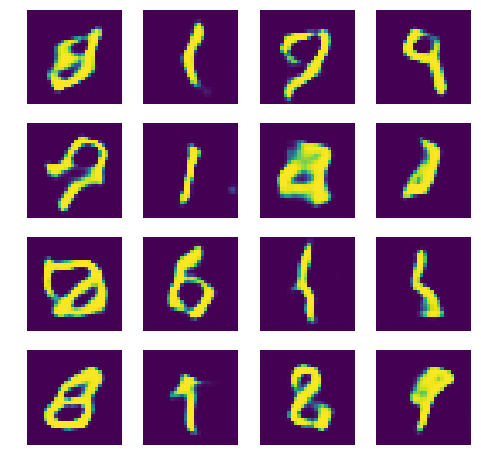

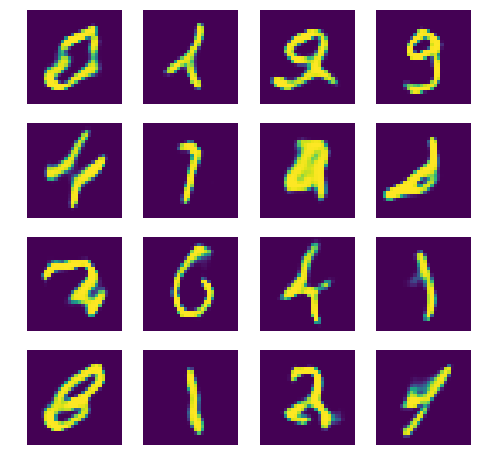

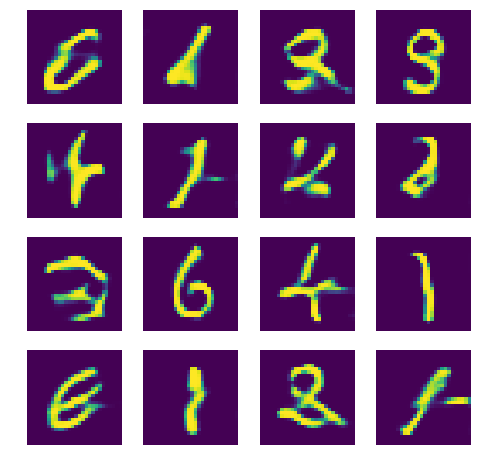

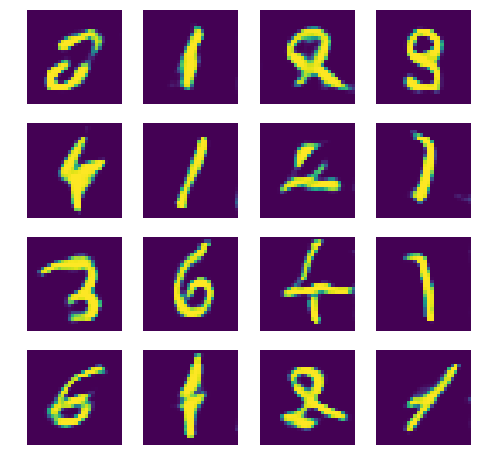

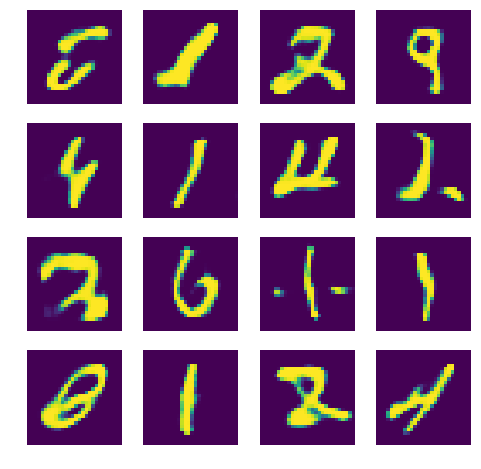

In [23]:
train_epochs = 1000
plot_interval = 200

# train over the selected train epochs
np.random.seed(initial_seed)

# get an array of random samples to be used to test the GAN at the end of the training
test_size = 16
test_noise = np.random.uniform(-1.0, 1.0, size=[test_size, 100])

def plot_img(i_w, synthetic_images, i, j):
    pyplot.figure(figsize=(i_w, i_w))
    for im in range( synthetic_images.shape[0] ):
        pyplot.subplot(4, 4, im+1)
        synthetic_image = np.reshape(synthetic_images[im, :, :, :], [i, j])
        pyplot.imshow(synthetic_image)
        pyplot.axis("off")

from tqdm import tqdm
for e in tqdm(range(train_epochs)):
    # stage 1: train the discriminator
    # select batch_size entries from the train set
    x_train__ = x_train_[np.random.randint(0, x_train_.shape[0], size=batch_size), :, :, :]
    # generate fake instances from random noise
    d_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    images_fake = generator.predict(d_noise)
    d_x = np.concatenate((x_train__, images_fake))
    # create a 2*batch_size array initially set to 1
    d_y = np.ones([2*batch_size, 1])
    # set the second half (fake images) to 0
    d_y[batch_size:, :] = 0
    # train the discriminator
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(d_x, d_y)

    # stage 2: train the generator-discriminator as adversarial
    # create random input noise
    input_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    gan_y = np.ones([batch_size, 1])
    discriminator.trainable = False
    ga_loss = gan.train_on_batch(input_noise, gan_y)
    print "%d: [Discriminator loss: %f, acc: %f] "\
            "[GA loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1], ga_loss[0], ga_loss[1])

    # plot after plot_interval epochs
    if (e+1)%plot_interval == 0:
        # plot the output images from the test noise
        synthetic_images = generator.predict(test_noise)
        i_w = test_size / 2
        plot_img(i_w, synthetic_images, x_train__.shape[1], x_train__.shape[2])